<a href="https://colab.research.google.com/github/patrickherbeth/algoritimos_machine_learning/blob/master/BPI_Challenge_2017_temporal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About the dataset

---


This event log belongs to a Dutch financial institute loan application process. The data includes all orders filed in an online system in 2016 and its subsequent events until February 1, 2017, 3:11 pm. The company providing the data and the process under consideration is the same as doi: 10.4121 / uuid: 3926db30-f712-4394-aebc-75976070e91f. However, the process support system has changed in the meantime. In particular, the system now allows multiple offers per application. These offers can be tracked using their IDs in the log.

The data is provided in two files:

The application event log. This event log contains all events with the application as the case ID. Any event related to an offer also refers to an OfferID.

The offer event log. This event log contains all events related to offers, with those offers as a case ID. For each offer, a corresponding application is available.

#Analyze and Pre-Processing

###First, for the notebook to function, it is necessary to load the libraries used in the project.

**Importing libraries**

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import re
import datetime
import matplotlib.pyplot as plt

from google.colab import drive
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from datetime import timedelta
from matplotlib import pyplot
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RepeatedStratifiedKFold

%matplotlib inline

### Now load the dataset through the CSV file and pre-processing will be done

**Importing application event log data**

In [7]:
application_df = pd.read_csv('BPI_Challenge_2017.csv')

In [8]:
application_df.columns.values

array(['Action', 'org:resource', 'concept:name', 'EventOrigin', 'EventID',
       'lifecycle:transition', 'time:timestamp', 'case:LoanGoal',
       'case:ApplicationType', 'case:concept:name',
       'case:RequestedAmount', 'FirstWithdrawalAmount', 'NumberOfTerms',
       'Accepted', 'MonthlyCost', 'Selected', 'CreditScore',
       'OfferedAmount', 'OfferID'], dtype=object)

In [9]:
fix_cols_names = lambda x: re.sub( '(?<!^)(?=[A-Z])', '_', x.replace('ID','Id')).lower().replace(':','_').replace('__','_')
fixed_app_cols = [fix_cols_names(col) for col in application_df.columns]
fixed_app_cols

['action',
 'org_resource',
 'concept_name',
 'event_origin',
 'event_id',
 'lifecycle_transition',
 'time_timestamp',
 'case_loan_goal',
 'case_application_type',
 'case_concept_name',
 'case_requested_amount',
 'first_withdrawal_amount',
 'number_of_terms',
 'accepted',
 'monthly_cost',
 'selected',
 'credit_score',
 'offered_amount',
 'offer_id']

In [10]:
application_df.columns = fixed_app_cols
application_df.head()

,action,org_resource,concept_name,event_origin,event_id,lifecycle_transition,time_timestamp,case_loan_goal,case_application_type,case_concept_name,case_requested_amount,first_withdrawal_amount,number_of_terms,accepted,monthly_cost,selected,credit_score,offered_amount,offer_id
0,Created,User_1,A_Create Application,Application,Application_652823628,complete,2016-01-01 09:51:15.304000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,statechange,User_1,A_Submitted,Application,ApplState_1582051990,complete,2016-01-01 09:51:15.352000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Created,User_1,W_Handle leads,Workflow,Workitem_1298499574,schedule,2016-01-01 09:51:15.774000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Deleted,User_1,W_Handle leads,Workflow,Workitem_1673366067,withdraw,2016-01-01 09:52:36.392000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Created,User_1,W_Complete application,Workflow,Workitem_1493664571,schedule,2016-01-01 09:52:36.403000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [235]:
application_df.dtypes

action                      object
org_resource                object
concept_name                object
event_origin                object
event_id                    object
lifecycle_transition        object
time_timestamp              object
case_loan_goal              object
case_application_type       object
case_concept_name           object
case_requested_amount      float64
first_withdrawal_amount    float64
number_of_terms            float64
accepted                    object
monthly_cost               float64
selected                    object
credit_score               float64
offered_amount             float64
offer_id                    object
dtype: object

In [ ]:
application_df['concept_name'].value_counts()

W_Validate application        209496
W_Call after offers           191092
W_Call incomplete files       168529
W_Complete application        148900
W_Handle leads                 47264
O_Created                      42995
O_Create Offer                 42995
O_Sent (mail and online)       39707
A_Validating                   38816
A_Concept                      31509
A_Accepted                     31509
A_Create Application           31509
A_Complete                     31362
O_Returned                     23305
A_Incomplete                   23055
O_Cancelled                    20898
A_Submitted                    20423
A_Pending                      17228
O_Accepted                     17228
A_Cancelled                    10431
O_Refused                       4695
A_Denied                        3753
W_Assess potential fraud        3282
O_Sent (online only)            2026
W_Shortened completion           238
W_Personal Loan collection        22
Name: concept_name, dtype: int64

#Explorative Analysis: 

###Exploratory data analysis (AED) is an approach to the analysis of data sets in order to summarize their main characteristics

In [11]:
# Format datetime
application_df['datetime'] = pd.to_datetime(application_df.time_timestamp)
application_df['datetime'] = application_df['datetime'].dt.strftime('%Y-%m-%d')

application_df['month_datetime'] = pd.to_datetime(application_df.datetime)
application_df['month_datetime'] = application_df['month_datetime'].dt.strftime('%m').astype(int)
application_df['month_datetime'].value_counts()

7     118526
9     114592
8     113052
10    111464
11    104946
6     104304
12     96768
3      95614
2      89088
5      85468
1      85216
4      83229
Name: month_datetime, dtype: int64


###**1 - Finding the application start date.**
### We will now find the application start date

In [12]:
apps_start_date = (application_df[application_df['concept_name'] == 'A_Create Application']
                    .filter(['case_concept_name','time_timestamp'])
                    .rename(index=str, columns={'time_timestamp':'start_date'}))
 
# Formatar start_date
apps_start_date['start_date'] = pd.to_datetime(apps_start_date.start_date)
apps_start_date['start_date'] = apps_start_date['start_date'].dt.strftime('%Y-%m-%d')

apps_start_date['start_date'] = pd.to_datetime(apps_start_date.start_date)
apps_start_date['month_start_date'] = apps_start_date['start_date'].dt.strftime('%m').astype(int)

apps_start_date

,case_concept_name,start_date,month_start_date
0,Application_652823628,2016-01-01,1
40,Application_1691306052,2016-01-01,1
71,Application_428409768,2016-01-01,1
116,Application_1746793196,2016-01-01,1
200,Application_828200680,2016-01-01,1
...,...,...,...
1202068,Application_1107993134,2016-12-31,12
1202113,Application_2103458006,2016-12-31,12
1202136,Application_59622033,2016-12-31,12
1202193,Application_303923658,2016-12-31,12


###**2 - Finding the application closing date.**
### We will find the close date of the application

In [13]:
app_final_activities = ['A_Pending','A_Cancelled','A_Denied']
apps_end_date = (application_df[application_df['concept_name'].isin(app_final_activities)]
                    .groupby('case_concept_name')
                    .agg({'time_timestamp':'last'})
                    .rename(index=str, columns={'time_timestamp':'end_date'})
                    .reset_index())

# Formatar end_data
apps_end_date['end_date'] = pd.to_datetime(apps_end_date.end_date)
apps_end_date['end_date'] = apps_end_date['end_date'].dt.strftime('%Y-%m-%d')

# Create End Date Month

apps_end_date['end_date'] = pd.to_datetime(apps_end_date.end_date)
apps_end_date['month_end_date'] = apps_end_date['end_date'].dt.strftime('%m').astype(int)

apps_end_date

,case_concept_name,end_date,month_end_date
0,Application_1000086665,2016-09-05,9
1,Application_1000158214,2016-06-10,6
2,Application_1000311556,2016-05-05,5
3,Application_1000334415,2016-09-29,9
4,Application_1000339879,2016-03-30,3
...,...,...,...
31406,Application_999507989,2016-03-23,3
31407,Application_999544538,2016-07-26,7
31408,Application_999632431,2017-01-16,1
31409,Application_999993467,2016-07-19,7


### **4 - Merge the two dataset *apps_start_date*, *apps_end_date and aaplication_df***
###A merge is made between the start date and the closing date. so we can find the duration of the application

In [14]:
df = pd.merge(apps_start_date, apps_end_date, how='right', right_on='case_concept_name', left_on='case_concept_name')
df = pd.merge(df, application_df, how='inner', on='case_concept_name')

df

,case_concept_name,start_date,month_start_date,end_date,month_end_date,action,org_resource,concept_name,event_origin,event_id,lifecycle_transition,time_timestamp,case_loan_goal,case_application_type,case_requested_amount,first_withdrawal_amount,number_of_terms,accepted,monthly_cost,selected,credit_score,offered_amount,offer_id,datetime,month_datetime
0,Application_1000086665,2016-08-03,8,2016-09-05,9,Created,User_1,A_Create Application,Application,Application_1000086665,complete,2016-08-03 15:57:21.673000+00:00,"Other, see explanation",New credit,5000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-08-03,8
1,Application_1000086665,2016-08-03,8,2016-09-05,9,statechange,User_1,A_Submitted,Application,ApplState_161925113,complete,2016-08-03 15:57:21.734000+00:00,"Other, see explanation",New credit,5000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-08-03,8
2,Application_1000086665,2016-08-03,8,2016-09-05,9,Created,User_1,W_Handle leads,Workflow,Workitem_747707399,schedule,2016-08-03 15:57:21.963000+00:00,"Other, see explanation",New credit,5000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-08-03,8
3,Application_1000086665,2016-08-03,8,2016-09-05,9,Deleted,User_1,W_Handle leads,Workflow,Workitem_1030261128,withdraw,2016-08-03 15:58:28.286000+00:00,"Other, see explanation",New credit,5000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-08-03,8
4,Application_1000086665,2016-08-03,8,2016-09-05,9,Created,User_1,W_Complete application,Workflow,Workitem_1127124826,schedule,2016-08-03 15:58:28.293000+00:00,"Other, see explanation",New credit,5000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-08-03,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1198314,Application_999993812,2016-10-06,10,2016-10-24,10,Obtained,User_41,W_Call incomplete files,Workflow,Workitem_1102967432,resume,2016-10-20 08:19:28.812000+00:00,Caravan / Camper,New credit,30000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-10-20,10
1198315,Application_999993812,2016-10-06,10,2016-10-24,10,Released,User_41,W_Call incomplete files,Workflow,Workitem_454743075,suspend,2016-10-20 08:21:59.667000+00:00,Caravan / Camper,New credit,30000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-10-20,10
1198316,Application_999993812,2016-10-06,10,2016-10-24,10,statechange,User_68,O_Accepted,Offer,OfferState_1927291643,complete,2016-10-24 06:24:30.056000+00:00,Caravan / Camper,New credit,30000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Offer_913122697,2016-10-24,10
1198317,Application_999993812,2016-10-06,10,2016-10-24,10,statechange,User_68,A_Pending,Application,ApplState_1253134444,complete,2016-10-24 06:24:30.059000+00:00,Caravan / Camper,New credit,30000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-10-24,10


###**5 - Create features *Year, Day_Week, Period_of_the_year* and *Week***
###Some features are created to be able to make a temporal analysis.

In [15]:
df['year'] = pd.DatetimeIndex(df['datetime']).year
df['day_week'] = pd.DatetimeIndex(df['datetime']).dayofweek
df['period_of_the_year'] = pd.DatetimeIndex(df['datetime']).quarter
df['week'] = pd.DatetimeIndex(df['datetime']).strftime('%G%V')
df['month_datetime'] = pd.DatetimeIndex(df['datetime']).strftime('%m').astype(int)

df['month_datetime'].value_counts()

7     118526
9     114592
8     113052
10    111447
11    104647
6     104304
3      95614
12     95035
2      89008
5      85468
1      83397
4      83229
Name: month_datetime, dtype: int64

#**Exploratory issues**

## **1 Question** - How many applications have been completed

### **Count application amount finishined application per month**
### A sum was made to check how many applications were completed per month




In [16]:
events_per_month = df.month_end_date.value_counts().reset_index() \
                    .rename(index = str, columns = {'index':'month_end_date',
                                                    'month_end_date':'num_app'}) \
                    .sort_values('month_end_date') 
events_per_month

,month_end_date,num_app
10,1,85588
11,2,82794
6,3,96491
9,4,85940
8,5,86509
7,6,91951
1,7,115028
2,8,112913
3,9,111733
0,10,118772


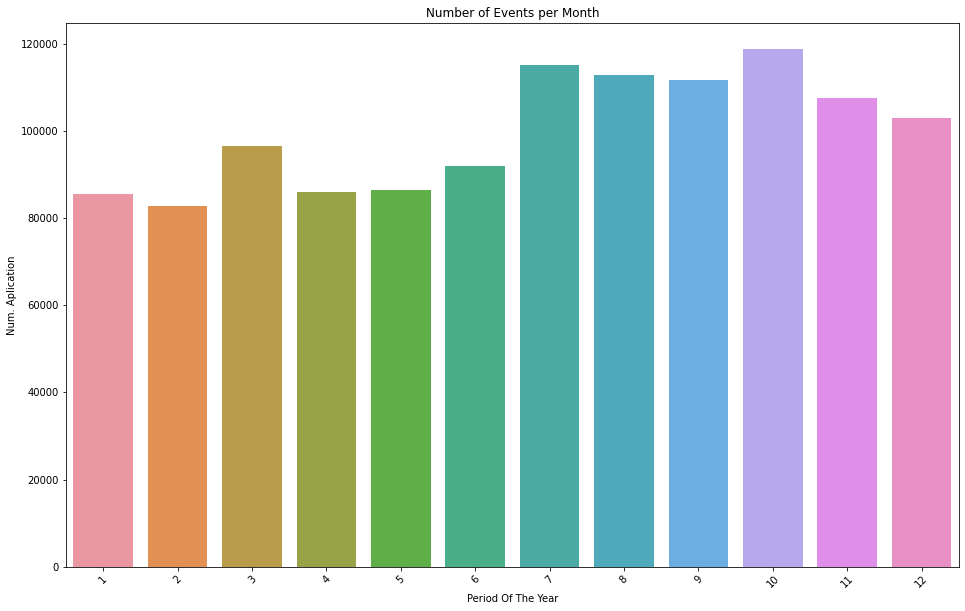

In [17]:
fig, ax = pyplot.subplots(figsize=(16,10))
g = sns.barplot(data = events_per_month, x ='month_end_date', y= 'num_app');
g.set_xlabel('Period Of The Year')
g.set_ylabel('Num. Aplication')
g.set_title('Number of Events per Month')
pyplot.xticks(rotation=45);

Text(0.5, 1.0, 'Number of Events per Month')

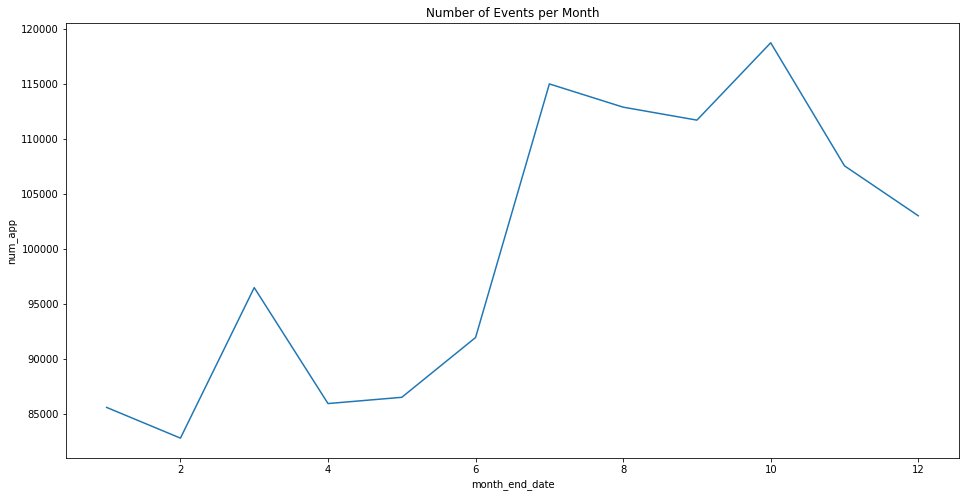

In [18]:
plt.figure(figsize=(16, 8))
plt.tight_layout()
ax = sns.lineplot(data = events_per_month, x ='month_end_date', y= 'num_app');
ax.set_title('Number of Events per Month')


## **2 Question Number** of applications per period?
## A sum was made to check how many applications were completed per quarter

In [19]:
events_per_period = df.period_of_the_year.value_counts().reset_index() \
                    .rename(index = str, columns = {'index':'period_of_the_year',
                                                    'period_of_the_year':'num_events'}) \
                    .sort_values('period_of_the_year') 
events_per_period

,period_of_the_year,num_events
3,1,268019
2,2,273001
0,3,346170
1,4,311129


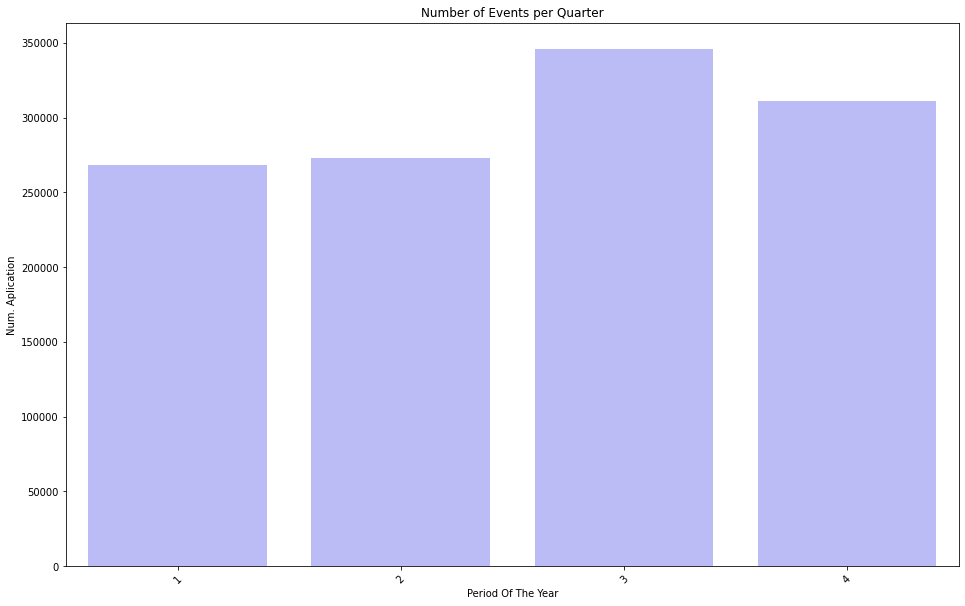

In [20]:
fig, ax = pyplot.subplots(figsize=(16,10))
g = sns.barplot(data = events_per_period, x ='period_of_the_year', y= 'num_events',  alpha=0.3, color="blue");
g.set_xlabel('Period Of The Year')
g.set_ylabel('Num. Aplication')
g.set_title('Number of Events per Quarter')
pyplot.xticks(rotation=45);


### **6 - Creates the features *monday_datetime*, *end_week* and start_date**
### A check is made to find out the Monday of each week to see if the application ended in the same week

In [21]:
df['datetime'] = pd.to_datetime(df.datetime)
df['monday_datetime'] = df['datetime'].dt.to_period('W').apply(lambda r: r.start_time)

df['start_date'] = pd.to_datetime(df.start_date)
df['start_week'] = df['start_date'].dt.to_period('W').apply(lambda r: r.start_time)

df['end_date'] = pd.to_datetime(df.end_date)
df['end_week'] = df['end_date'].dt.to_period('W').apply(lambda r: r.start_time)

df

,case_concept_name,start_date,month_start_date,end_date,month_end_date,action,org_resource,concept_name,event_origin,event_id,lifecycle_transition,time_timestamp,case_loan_goal,case_application_type,case_requested_amount,first_withdrawal_amount,number_of_terms,accepted,monthly_cost,selected,credit_score,offered_amount,offer_id,datetime,month_datetime,year,day_week,period_of_the_year,week,monday_datetime,start_week,end_week
0,Application_1000086665,2016-08-03,8,2016-09-05,9,Created,User_1,A_Create Application,Application,Application_1000086665,complete,2016-08-03 15:57:21.673000+00:00,"Other, see explanation",New credit,5000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-08-03,8,2016,2,3,201631,2016-08-01,2016-08-01,2016-09-05
1,Application_1000086665,2016-08-03,8,2016-09-05,9,statechange,User_1,A_Submitted,Application,ApplState_161925113,complete,2016-08-03 15:57:21.734000+00:00,"Other, see explanation",New credit,5000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-08-03,8,2016,2,3,201631,2016-08-01,2016-08-01,2016-09-05
2,Application_1000086665,2016-08-03,8,2016-09-05,9,Created,User_1,W_Handle leads,Workflow,Workitem_747707399,schedule,2016-08-03 15:57:21.963000+00:00,"Other, see explanation",New credit,5000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-08-03,8,2016,2,3,201631,2016-08-01,2016-08-01,2016-09-05
3,Application_1000086665,2016-08-03,8,2016-09-05,9,Deleted,User_1,W_Handle leads,Workflow,Workitem_1030261128,withdraw,2016-08-03 15:58:28.286000+00:00,"Other, see explanation",New credit,5000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-08-03,8,2016,2,3,201631,2016-08-01,2016-08-01,2016-09-05
4,Application_1000086665,2016-08-03,8,2016-09-05,9,Created,User_1,W_Complete application,Workflow,Workitem_1127124826,schedule,2016-08-03 15:58:28.293000+00:00,"Other, see explanation",New credit,5000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-08-03,8,2016,2,3,201631,2016-08-01,2016-08-01,2016-09-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1198314,Application_999993812,2016-10-06,10,2016-10-24,10,Obtained,User_41,W_Call incomplete files,Workflow,Workitem_1102967432,resume,2016-10-20 08:19:28.812000+00:00,Caravan / Camper,New credit,30000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-10-20,10,2016,3,4,201642,2016-10-17,2016-10-03,2016-10-24
1198315,Application_999993812,2016-10-06,10,2016-10-24,10,Released,User_41,W_Call incomplete files,Workflow,Workitem_454743075,suspend,2016-10-20 08:21:59.667000+00:00,Caravan / Camper,New credit,30000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-10-20,10,2016,3,4,201642,2016-10-17,2016-10-03,2016-10-24
1198316,Application_999993812,2016-10-06,10,2016-10-24,10,statechange,User_68,O_Accepted,Offer,OfferState_1927291643,complete,2016-10-24 06:24:30.056000+00:00,Caravan / Camper,New credit,30000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Offer_913122697,2016-10-24,10,2016,0,4,201643,2016-10-24,2016-10-03,2016-10-24
1198317,Application_999993812,2016-10-06,10,2016-10-24,10,statechange,User_68,A_Pending,Application,ApplState_1253134444,complete,2016-10-24 06:24:30.059000+00:00,Caravan / Camper,New credit,30000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-10-24,10,2016,0,4,201643,2016-10-24,2016-10-03,2016-10-24



### **7 - Creates the features *label* that checks if the activity was closed that week.**
###The label is created to verify that the application has been completed within one week.


In [22]:
df = df.assign(label = lambda x: x.month_start_date == x.month_end_date)
df['label'].value_counts()

False    757526
True     440793
Name: label, dtype: int64

###**8 - Days of application duration**
###Creates features containing the number of days the application has lasted.

In [23]:
df['start_date'] = pd.to_datetime(df.start_date)
df['application_duration'] = df['end_date'] - df['start_date']
df['application_duration'] = pd.to_numeric(df['application_duration'].dt.days, downcast='integer')

df

,case_concept_name,start_date,month_start_date,end_date,month_end_date,action,org_resource,concept_name,event_origin,event_id,lifecycle_transition,time_timestamp,case_loan_goal,case_application_type,case_requested_amount,first_withdrawal_amount,number_of_terms,accepted,monthly_cost,selected,credit_score,offered_amount,offer_id,datetime,month_datetime,year,day_week,period_of_the_year,week,monday_datetime,start_week,end_week,label,application_duration
0,Application_1000086665,2016-08-03,8,2016-09-05,9,Created,User_1,A_Create Application,Application,Application_1000086665,complete,2016-08-03 15:57:21.673000+00:00,"Other, see explanation",New credit,5000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-08-03,8,2016,2,3,201631,2016-08-01,2016-08-01,2016-09-05,False,33
1,Application_1000086665,2016-08-03,8,2016-09-05,9,statechange,User_1,A_Submitted,Application,ApplState_161925113,complete,2016-08-03 15:57:21.734000+00:00,"Other, see explanation",New credit,5000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-08-03,8,2016,2,3,201631,2016-08-01,2016-08-01,2016-09-05,False,33
2,Application_1000086665,2016-08-03,8,2016-09-05,9,Created,User_1,W_Handle leads,Workflow,Workitem_747707399,schedule,2016-08-03 15:57:21.963000+00:00,"Other, see explanation",New credit,5000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-08-03,8,2016,2,3,201631,2016-08-01,2016-08-01,2016-09-05,False,33
3,Application_1000086665,2016-08-03,8,2016-09-05,9,Deleted,User_1,W_Handle leads,Workflow,Workitem_1030261128,withdraw,2016-08-03 15:58:28.286000+00:00,"Other, see explanation",New credit,5000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-08-03,8,2016,2,3,201631,2016-08-01,2016-08-01,2016-09-05,False,33
4,Application_1000086665,2016-08-03,8,2016-09-05,9,Created,User_1,W_Complete application,Workflow,Workitem_1127124826,schedule,2016-08-03 15:58:28.293000+00:00,"Other, see explanation",New credit,5000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-08-03,8,2016,2,3,201631,2016-08-01,2016-08-01,2016-09-05,False,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1198314,Application_999993812,2016-10-06,10,2016-10-24,10,Obtained,User_41,W_Call incomplete files,Workflow,Workitem_1102967432,resume,2016-10-20 08:19:28.812000+00:00,Caravan / Camper,New credit,30000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-10-20,10,2016,3,4,201642,2016-10-17,2016-10-03,2016-10-24,True,18
1198315,Application_999993812,2016-10-06,10,2016-10-24,10,Released,User_41,W_Call incomplete files,Workflow,Workitem_454743075,suspend,2016-10-20 08:21:59.667000+00:00,Caravan / Camper,New credit,30000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-10-20,10,2016,3,4,201642,2016-10-17,2016-10-03,2016-10-24,True,18
1198316,Application_999993812,2016-10-06,10,2016-10-24,10,statechange,User_68,O_Accepted,Offer,OfferState_1927291643,complete,2016-10-24 06:24:30.056000+00:00,Caravan / Camper,New credit,30000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Offer_913122697,2016-10-24,10,2016,0,4,201643,2016-10-24,2016-10-03,2016-10-24,True,18
1198317,Application_999993812,2016-10-06,10,2016-10-24,10,statechange,User_68,A_Pending,Application,ApplState_1253134444,complete,2016-10-24 06:24:30.059000+00:00,Caravan / Camper,New credit,30000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-10-24,10,2016,0,4,201643,2016-10-24,2016-10-03,2016-10-24,True,18


# **Classification**

##**Question:** If the application was completed in the week?

###Now the classification will be made using 4 classification algorithms: LogisticRegression, DecisionTree, RandomForest and K-Nearest_Neighbors.

###**Some metrics were used for the evaluation.**


###Model evaluation

- Accuracy: the ratio of correctly predicted observation to the total observations
- Precision: proportion of positive identifications that was actually correct
- Recall: proportion of actual positives that was identified correctly
- F1 Score: weighted average of Precision and Recall

#### **Format start_date and start_week:** To use the features start date, it is necessary to format to inform the week number of the year.

In [24]:
df['start_date'] = pd.to_datetime(df.start_date)
df['start_date'] = pd.DatetimeIndex(df['start_date']).strftime('%G%V')

df['start_week'] = pd.to_datetime(df.start_week)
df['start_week'] = pd.DatetimeIndex(df['start_week']).strftime('%G%V')

#### **Create dataset copy_df:** Created a copy of the dataset to be able to manipulate the data

In [69]:
copy_df = df[['case_concept_name',	'start_date',	'start_week',	'month_datetime',	'day_week',	'period_of_the_year',	'label']].copy(deep=True)
copy_df.dropna(inplace=True)
copy_df.drop_duplicates(inplace=True)

dataset = copy_df

####**Splitting data:**The model is divided between test and training data

In [70]:
#splitting data in train and test sets (70/30)

x_train, x_test = train_test_split(dataset['case_concept_name'].drop_duplicates(), test_size=0.3)
x_train = dataset.merge(x_train, on="case_concept_name")
x_test = dataset.merge(x_test, on="case_concept_name")

y_test = x_test['label'].astype(int)
y_train = x_train['label'].astype(int)
x_train = x_train.drop(['case_concept_name', 'label'], axis=1)
x_test = x_test.drop(['case_concept_name', 'label'], axis=1)

#**Classifiers**

####**Create result dataframe novo_df**: To record the results and view the results it was necessary to create a dataset to store the results.



In [75]:
novo_df = pd.DataFrame()

###Logic Regression

In [76]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)

y_pred = logreg.predict(x_test)

acurracy = logreg.score(x_test, y_test)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
average_precision = average_precision_score(y_test, y_pred)
f1_score = metrics.f1_score(y_test, y_pred)

row_df = pd.DataFrame([pd.Series(['LogisticRegression', 'imbalaced', acurracy, precision, recall, average_precision, f1_score])])

novo_df = pd.concat([row_df, novo_df])

print('Precision score: {0:0.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Recall score: {0:0.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Average precision-recall score: {0:0.2f}'.format(average_precision_score(y_test, y_pred)))
print('Average F1 Score score: {0:0.2f}'.format(metrics.f1_score(y_test, y_pred)))

novo_df

Precision score: 0.34
Recall score: 0.50
Average precision-recall score: 0.31
Average F1 Score score: 0.00


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,0,1,2,3,4,5,6
0,LogisticRegression,imbalaced,0.686918,0.343459,0.5,0.313082,0.0


###Random Forest

In [77]:
clf = RandomForestClassifier(n_estimators=200, random_state=100)

#Train the model using 
clf.fit(x_train,y_train)

y_pred = clf.predict(x_test)

acurracy = training_accry = clf.score(x_test, y_test)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
average_precision = average_precision_score(y_test, y_pred)
f1_score = metrics.f1_score(y_test, y_pred)

row_df = pd.DataFrame([pd.Series(['RandomForest', 'imbalaced', acurracy, precision, recall, average_precision, f1_score])])

novo_df = pd.concat([row_df, novo_df])

print('Precision score: {0:0.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Recall score: {0:0.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Average precision-recall score: {0:0.2f}'.format(average_precision_score(y_test, y_pred)))
print('Average F1 Score score: {0:0.2f}'.format(metrics.f1_score(y_test, y_pred)))

novo_df

Precision score: 0.75
Recall score: 0.77
Average precision-recall score: 0.55
Average F1 Score score: 0.67


,0,1,2,3,4,5,6
0,RandomForest,imbalaced,0.784152,0.750674,0.765348,0.545919,0.674724
0,LogisticRegression,imbalaced,0.686918,0.343459,0.500000,0.313082,0.000000


###Decision Tree

In [78]:
clf = DecisionTreeClassifier().fit(x_train, y_train)

y_pred = clf.predict(x_test)

acurracy  = clf.score(x_test, y_test)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
average_precision = average_precision_score(y_test, y_pred)
f1_score = metrics.f1_score(y_test, y_pred)

row_df = pd.DataFrame([pd.Series(['DecisionTree', 'imbalaced', acurracy, precision, recall, average_precision, f1_score])])

novo_df = pd.concat([row_df, novo_df])

print('Precision score: {0:0.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Recall score: {0:0.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Average precision-recall score: {0:0.2f}'.format(average_precision_score(y_test, y_pred)))
print('Average F1 Score score: {0:0.2f}'.format(metrics.f1_score(y_test, y_pred)))

novo_df.head()

Precision score: 0.75
Recall score: 0.76
Average precision-recall score: 0.54
Average F1 Score score: 0.67


,0,1,2,3,4,5,6
0,DecisionTree,imbalaced,0.783634,0.749749,0.762743,0.544030,0.671664
0,RandomForest,imbalaced,0.784152,0.750674,0.765348,0.545919,0.674724
0,LogisticRegression,imbalaced,0.686918,0.343459,0.500000,0.313082,0.000000


###K-Nearest Neighbors

In [79]:
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)

y_pred = clf.predict(x_test)

acurracy = training_accry = clf.score(x_test, y_test)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
average_precision = average_precision_score(y_test, y_pred)
f1_score = metrics.f1_score(y_test, y_pred)

row_df = pd.DataFrame([pd.Series(['K-Nearest_Neighbors', 'imbalaced', acurracy, precision, recall, average_precision, f1_score])])

novo_df = pd.concat([row_df, novo_df])

print('Precision score: {0:0.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Recall score: {0:0.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Average precision-recall score: {0:0.2f}'.format(average_precision_score(y_test, y_pred)))
print('Average F1 Score score: {0:0.2f}'.format(metrics.f1_score(y_test, y_pred)))

novo_df

Precision score: 0.75
Recall score: 0.76
Average precision-recall score: 0.54
Average F1 Score score: 0.67


,0,1,2,3,4,5,6
0,K-Nearest_Neighbors,imbalaced,0.783634,0.749749,0.762743,0.544030,0.671664
0,DecisionTree,imbalaced,0.783634,0.749749,0.762743,0.544030,0.671664
0,RandomForest,imbalaced,0.784152,0.750674,0.765348,0.545919,0.674724
0,LogisticRegression,imbalaced,0.686918,0.343459,0.500000,0.313082,0.000000


###Confusion Matrix



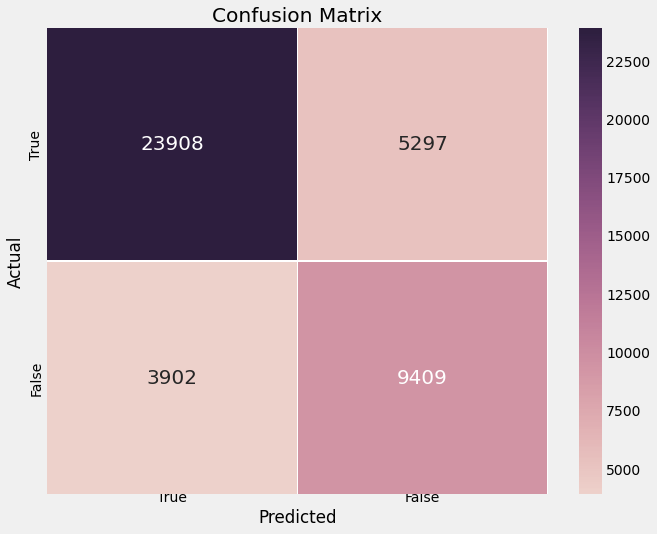

In [80]:
plt.figure(figsize=(10,8))
ax = (sns.heatmap(metrics.confusion_matrix(y_test, y_pred), annot=True, annot_kws={"size": 20}, 
                 linewidths=.1, fmt='d', cmap=sns.cubehelix_palette(as_cmap=True)))
plt.yticks([0.5,1.5,2], ['True', 'False'], va='center', fontsize=14)
plt.xticks([0.5,1.5,2], ['True', 'False'], va='center', fontsize=14)
ax.set_title("Confusion Matrix")
ax.set(xlabel="Predicted", ylabel="Actual");
plt.show()

###Features import

([<matplotlib.axis.XTick at 0x7fed64a05e48>,
 [Text(0, 0, 'start_date'),
  Text(0, 0, 'start_week'),
  Text(0, 0, 'month_datetime'),
  Text(0, 0, 'day_week'),
  Text(0, 0, 'period_of_the_year')])

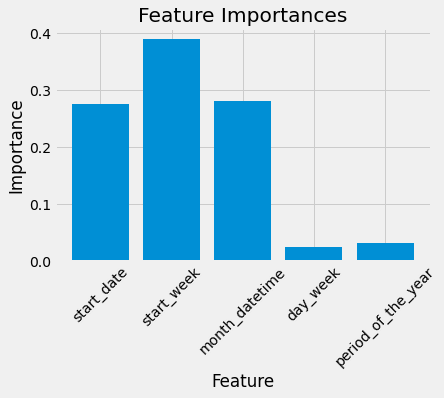

In [81]:
feature_list = ['start_date',	'start_week',	'month_datetime',	'day_week',	'period_of_the_year']
feature_imp = pd.Series(clf.feature_importances_,index=feature_list)

plt.style.use('fivethirtyeight')
x_values = list(range(len(feature_imp)))
plt.bar(x_values, feature_imp, orientation = 'vertical')
plt.xticks(x_values, feature_list)

plt.ylabel('Importance'); plt.xlabel('Feature'); plt.title('Feature Importances')
plt.xticks(x_values, feature_list, rotation='45')

#**Unbalanced classes**

####Traditional learning algorithms induced by complex and highly unbalanced training sets have shown difficulty in differentiating between groups. The tendency is to produce models (or rules) of classification that favor the class with the highest probability of occurrence (majority), resulting in a low recognition rate for the minority group.

###**Cost-sensitive Learning**
###Cost-sensitive learning is a subfield of machine learning that takes the costs of prediction errors (and potentially other costs) into account when training a machine learning model. It is a field of study that is closely related to the field of imbalanced learning that is concerned with classification on datasets with a skewed class distribution. As such, many conceptualizations and techniques developed and used for cost-sensitive learning can be adopted for imbalanced classification problems. Weights are calculated and classes are assigned.

### In this technique the weights are assigned to the categories, the calculation for assigning the weights is below:
weighting = n_samples / (n_classes * n_sample_with_class)

In [82]:
total_size = len(copy_df)
minority_size = len(copy_df[copy_df['label'] == True])
major_size = len(copy_df[copy_df['label'] == False])

falseW = total_size / (total_size * major_size)
trueW = total_size / (total_size * minority_size)

print("Total: ", total_size)
print("Minority: ", minority_size)
print("Majority: ", major_size)


print('The weight value of the False class is {:.10f}'.format(round(falseW, 10)))
print('The weight value of the True class is {:.10f}'.format(round(trueW, 10)))


Total:  141701
Minority:  43973
Majority:  97728
The weight value of the False class is 0.0000102325
The weight value of the True class is 0.0000227412


###**Viability of unbalanced data**

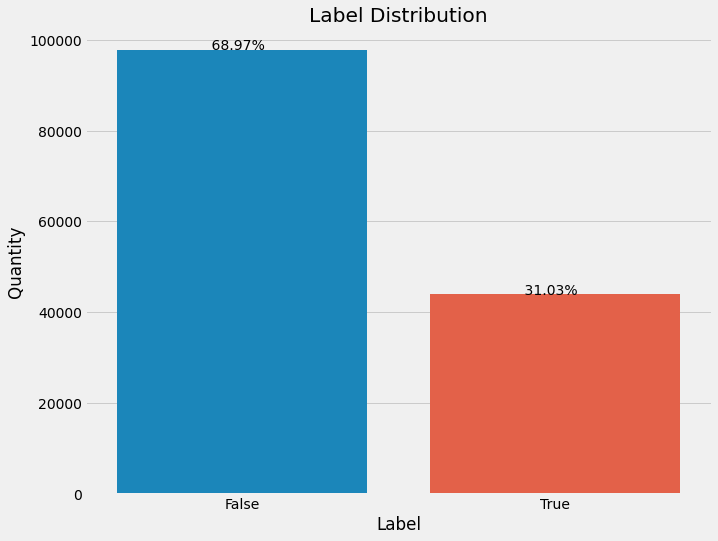

In [83]:
space = '                     '
plt.figure(figsize=[10,8])
labels_occ = copy_df['label']
ax = sns.barplot(x=labels_occ.value_counts().index, y=labels_occ.value_counts(), orient='v')

for p in ax.patches:
    (ax.annotate(space + '{:.2f}%'.format(p.get_height()/len(labels_occ)*100), 
                 (p.get_x(), p.get_height()+1), fontsize=14))
ax.set(xlabel="Label", ylabel = "Quantity")
ax.set_title("Label Distribution")
plt.show()


###**Classifiers**

###Logic Regression

In [84]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)

y_pred = logreg.predict(x_test)

acurracy = training_accry = clf.score(x_test, y_test)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
average_precision = average_precision_score(y_test, y_pred)
f1_score = metrics.f1_score(y_test, y_pred)

row_df = pd.DataFrame([pd.Series(['LogisticRegression', 'cost_sensitive_learning', acurracy, precision, recall, average_precision, f1_score])])

novo_df = pd.concat([row_df, novo_df])

print('Precision score: {0:0.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Recall score: {0:0.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Average precision-recall score: {0:0.2f}'.format(average_precision_score(y_test, y_pred)))
print('Average F1 Score score: {0:0.2f}'.format(metrics.f1_score(y_test, y_pred)))

novo_df

Precision score: 0.34
Recall score: 0.50
Average precision-recall score: 0.31
Average F1 Score score: 0.00


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,0,1,2,3,4,5,6
0,LogisticRegression,cost_sensitive_learning,0.783634,0.343459,0.500000,0.313082,0.000000
0,K-Nearest_Neighbors,imbalaced,0.783634,0.749749,0.762743,0.544030,0.671664
0,DecisionTree,imbalaced,0.783634,0.749749,0.762743,0.544030,0.671664
0,RandomForest,imbalaced,0.784152,0.750674,0.765348,0.545919,0.674724
0,LogisticRegression,imbalaced,0.686918,0.343459,0.500000,0.313082,0.000000


###Random Forest

In [85]:
clf = RandomForestClassifier(n_estimators=200, random_state=100)

clf.fit(x_train,y_train)

y_pred = clf.predict(x_test)

acurracy = training_accry = clf.score(x_test, y_test)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
average_precision = average_precision_score(y_test, y_pred)
f1_score = metrics.f1_score(y_test, y_pred)

row_df = pd.DataFrame([pd.Series(['RandomForest', 'cost_sensitive_learning', acurracy, precision, recall, average_precision, f1_score])])

novo_df = pd.concat([row_df, novo_df])

print('Precision score: {0:0.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Recall score: {0:0.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Average precision-recall score: {0:0.2f}'.format(average_precision_score(y_test, y_pred)))
print('Average F1 Score score: {0:0.2f}'.format(metrics.f1_score(y_test, y_pred)))

novo_df

Precision score: 0.75
Recall score: 0.77
Average precision-recall score: 0.55
Average F1 Score score: 0.67


,0,1,2,3,4,5,6
0,RandomForest,cost_sensitive_learning,0.784152,0.750674,0.765348,0.545919,0.674724
0,LogisticRegression,cost_sensitive_learning,0.783634,0.343459,0.500000,0.313082,0.000000
0,K-Nearest_Neighbors,imbalaced,0.783634,0.749749,0.762743,0.544030,0.671664
0,DecisionTree,imbalaced,0.783634,0.749749,0.762743,0.544030,0.671664
0,RandomForest,imbalaced,0.784152,0.750674,0.765348,0.545919,0.674724
0,LogisticRegression,imbalaced,0.686918,0.343459,0.500000,0.313082,0.000000


###Decision Tree

In [86]:
clf = DecisionTreeClassifier().fit(x_train, y_train)

y_pred = clf.predict(x_test)

acurracy = training_accry = clf.score(x_test, y_test)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
average_precision = average_precision_score(y_test, y_pred)
f1_score = metrics.f1_score(y_test, y_pred)

row_df = pd.DataFrame([pd.Series(['DecisionTree', 'cost_sensitive_learning', acurracy, precision, recall, average_precision, f1_score])])

novo_df = pd.concat([row_df, novo_df])

print('Precision score: {0:0.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Recall score: {0:0.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Average precision-recall score: {0:0.2f}'.format(average_precision_score(y_test, y_pred)))
print('Average F1 Score score: {0:0.2f}'.format(metrics.f1_score(y_test, y_pred)))

novo_df

Precision score: 0.75
Recall score: 0.76
Average precision-recall score: 0.54
Average F1 Score score: 0.67


,0,1,2,3,4,5,6
0,DecisionTree,cost_sensitive_learning,0.783634,0.749749,0.762743,0.544030,0.671664
0,RandomForest,cost_sensitive_learning,0.784152,0.750674,0.765348,0.545919,0.674724
0,LogisticRegression,cost_sensitive_learning,0.783634,0.343459,0.500000,0.313082,0.000000
0,K-Nearest_Neighbors,imbalaced,0.783634,0.749749,0.762743,0.544030,0.671664
0,DecisionTree,imbalaced,0.783634,0.749749,0.762743,0.544030,0.671664
0,RandomForest,imbalaced,0.784152,0.750674,0.765348,0.545919,0.674724
0,LogisticRegression,imbalaced,0.686918,0.343459,0.500000,0.313082,0.000000


###K-Nearest Neighbors

In [87]:
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)

y_pred = clf.predict(x_test)

acurracy = training_accry = clf.score(x_test, y_test)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
average_precision = average_precision_score(y_test, y_pred)
f1_score = metrics.f1_score(y_test, y_pred)

row_df = pd.DataFrame([pd.Series(['K-Nearest_Neighbors', 'cost_sensitive_learning', acurracy, precision, recall, average_precision, f1_score])])

novo_df = pd.concat([row_df, novo_df])

print('Precision score: {0:0.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Recall score: {0:0.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Average precision-recall score: {0:0.2f}'.format(average_precision_score(y_test, y_pred)))
print('Average F1 Score score: {0:0.2f}'.format(metrics.f1_score(y_test, y_pred)))

novo_df

Precision score: 0.75
Recall score: 0.76
Average precision-recall score: 0.54
Average F1 Score score: 0.67


,0,1,2,3,4,5,6
0,K-Nearest_Neighbors,cost_sensitive_learning,0.783634,0.749749,0.762743,0.544030,0.671664
0,DecisionTree,cost_sensitive_learning,0.783634,0.749749,0.762743,0.544030,0.671664
0,RandomForest,cost_sensitive_learning,0.784152,0.750674,0.765348,0.545919,0.674724
0,LogisticRegression,cost_sensitive_learning,0.783634,0.343459,0.500000,0.313082,0.000000
0,K-Nearest_Neighbors,imbalaced,0.783634,0.749749,0.762743,0.544030,0.671664
0,DecisionTree,imbalaced,0.783634,0.749749,0.762743,0.544030,0.671664
0,RandomForest,imbalaced,0.784152,0.750674,0.765348,0.545919,0.674724
0,LogisticRegression,imbalaced,0.686918,0.343459,0.500000,0.313082,0.000000


###Confusion Matrix



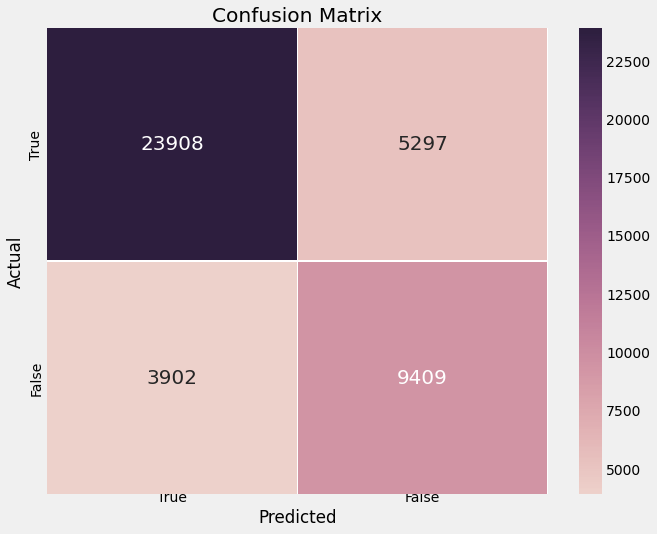

In [88]:
plt.figure(figsize=(10,8))
ax = (sns.heatmap(metrics.confusion_matrix(y_test, y_pred), annot=True, annot_kws={"size": 20}, 
                 linewidths=.1, fmt='d', cmap=sns.cubehelix_palette(as_cmap=True)))
plt.yticks([0.5,1.5,2], ['True', 'False'], va='center', fontsize=14)
plt.xticks([0.5,1.5,2], ['True', 'False'], va='center', fontsize=14)
ax.set_title("Confusion Matrix")
ax.set(xlabel="Predicted", ylabel="Actual");
plt.show()

###Features import

([<matplotlib.axis.XTick at 0x7fed6749dac8>,
 [Text(0, 0, 'start_date'),
  Text(0, 0, 'start_week'),
  Text(0, 0, 'month_datetime'),
  Text(0, 0, 'day_week'),
  Text(0, 0, 'period_of_the_year')])

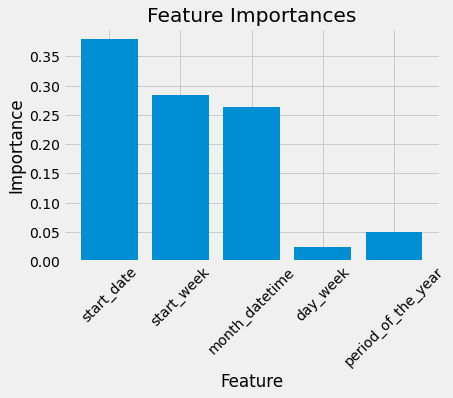

In [89]:
feature_list = ['start_date',	'start_week',	'month_datetime',	'day_week',	'period_of_the_year']
feature_imp = pd.Series(clf.feature_importances_,index=feature_list)

plt.style.use('fivethirtyeight')
x_values = list(range(len(feature_imp)))
plt.bar(x_values, feature_imp, orientation = 'vertical')
plt.xticks(x_values, feature_list)

plt.ylabel('Importance'); plt.xlabel('Feature'); plt.title('Feature Importances')
plt.xticks(x_values, feature_list, rotation='45')

###**Sampling (Amostragem)**

#### **I Balance SMOTE (Oversampling)**

In [90]:
from imblearn.over_sampling import SMOTE

# for reproducibility purposes
seed = 100
# SMOTE number of neighbors
k = 1

x_over = copy_df[['start_date',	'start_week',	 'month_datetime',	'day_week',	'period_of_the_year']].astype(int)
y_over = copy_df[['label']].astype(int)

sm = SMOTE(sampling_strategy='auto', k_neighbors=k, random_state=seed)

X_res_over, y_res_over = sm.fit_resample(x_over, y_over)

dataset = pd.concat([pd.DataFrame(X_res_over), pd.DataFrame(y_res_over)], axis=1)
dataset = pd.concat([copy_df['case_concept_name'], dataset], axis=1)

# rename the columns
dataset.columns = ['case_concept_name', 'start_date',	'start_week',	 'month_datetime',	'day_week',	'period_of_the_year', 'label']
dataset.dropna(inplace=True)
dataset.drop_duplicates(inplace=True)
dataset['label'].value_counts()

#splitting data in train and test sets (70/30)

x_train, x_test = train_test_split(dataset['case_concept_name'].drop_duplicates(), test_size=0.3)
x_train = dataset.merge(x_train, on="case_concept_name")
x_test = dataset.merge(x_test, on="case_concept_name")

y_test = x_test['label'].astype(int)
y_train = x_train['label'].astype(int)
x_train = x_train.drop(['case_concept_name', 'label'], axis=1)
x_test = x_test.drop(['case_concept_name', 'label'], axis=1)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


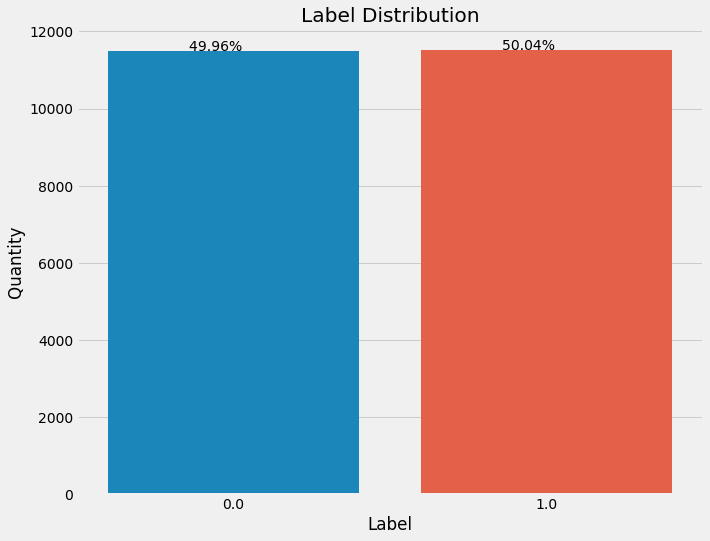

In [91]:
space = '                  '
plt.figure(figsize=[10,8])
labels_occ = dataset['label']
ax = sns.barplot(x=labels_occ.value_counts().index, y=labels_occ.value_counts(), orient='v')

for p in ax.patches:
    (ax.annotate(space + '{:.2f}%'.format(p.get_height()/len(labels_occ)*100), 
                 (p.get_x(), p.get_height()+1), fontsize=14))
ax.set(xlabel="Label", ylabel = "Quantity")
ax.set_title("Label Distribution")
plt.show()

###**Classifiers**

###Logic Regression

In [92]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)

y_pred = logreg.predict(x_test)

acurracy = training_accry = clf.score(x_test, y_test)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
average_precision = average_precision_score(y_test, y_pred)
f1_score = metrics.f1_score(y_test, y_pred)

row_df = pd.DataFrame([pd.Series(['LogisticRegression', 'oversampling', acurracy, precision, recall, average_precision, f1_score])])

novo_df = pd.concat([row_df, novo_df])

print('Precision score: {0:0.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Recall score: {0:0.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Average precision-recall score: {0:0.2f}'.format(average_precision_score(y_test, y_pred)))
print('Average F1 Score score: {0:0.2f}'.format(metrics.f1_score(y_test, y_pred)))

novo_df

Precision score: 0.25
Recall score: 0.50
Average precision-recall score: 0.50
Average F1 Score score: 0.66


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,0,1,2,3,4,5,6
0,LogisticRegression,oversampling,0.762552,0.248083,0.500000,0.496166,0.663250
0,K-Nearest_Neighbors,cost_sensitive_learning,0.783634,0.749749,0.762743,0.544030,0.671664
0,DecisionTree,cost_sensitive_learning,0.783634,0.749749,0.762743,0.544030,0.671664
0,RandomForest,cost_sensitive_learning,0.784152,0.750674,0.765348,0.545919,0.674724
0,LogisticRegression,cost_sensitive_learning,0.783634,0.343459,0.500000,0.313082,0.000000
0,K-Nearest_Neighbors,imbalaced,0.783634,0.749749,0.762743,0.544030,0.671664
0,DecisionTree,imbalaced,0.783634,0.749749,0.762743,0.544030,0.671664
0,RandomForest,imbalaced,0.784152,0.750674,0.765348,0.545919,0.674724
0,LogisticRegression,imbalaced,0.686918,0.343459,0.500000,0.313082,0.000000


###Random Forest

In [93]:
clf = RandomForestClassifier(n_estimators=200, random_state=100)

#Train the model using 
clf.fit(x_train,y_train)

y_pred = clf.predict(x_test)

acurracy = training_accry = clf.score(x_test, y_test)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
average_precision = average_precision_score(y_test, y_pred)
f1_score = metrics.f1_score(y_test, y_pred)

row_df = pd.DataFrame([pd.Series(['RandomForest', 'oversampling', acurracy, precision, recall, average_precision, f1_score])])

novo_df = pd.concat([row_df, novo_df])

print('Precision score: {0:0.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Recall score: {0:0.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Average precision-recall score: {0:0.2f}'.format(average_precision_score(y_test, y_pred)))
print('Average F1 Score score: {0:0.2f}'.format(metrics.f1_score(y_test, y_pred)))

novo_df

Precision score: 0.79
Recall score: 0.78
Average precision-recall score: 0.70
Average F1 Score score: 0.80


,0,1,2,3,4,5,6
0,RandomForest,oversampling,0.781363,0.791909,0.782084,0.704938,0.799042
0,LogisticRegression,oversampling,0.762552,0.248083,0.500000,0.496166,0.663250
0,K-Nearest_Neighbors,cost_sensitive_learning,0.783634,0.749749,0.762743,0.544030,0.671664
0,DecisionTree,cost_sensitive_learning,0.783634,0.749749,0.762743,0.544030,0.671664
0,RandomForest,cost_sensitive_learning,0.784152,0.750674,0.765348,0.545919,0.674724
0,LogisticRegression,cost_sensitive_learning,0.783634,0.343459,0.500000,0.313082,0.000000
0,K-Nearest_Neighbors,imbalaced,0.783634,0.749749,0.762743,0.544030,0.671664
0,DecisionTree,imbalaced,0.783634,0.749749,0.762743,0.544030,0.671664
0,RandomForest,imbalaced,0.784152,0.750674,0.765348,0.545919,0.674724
0,LogisticRegression,imbalaced,0.686918,0.343459,0.500000,0.313082,0.000000


###Decision Tree

In [94]:
clf = DecisionTreeClassifier().fit(x_train, y_train)

y_pred = clf.predict(x_test)

acurracy = training_accry = clf.score(x_test, y_test)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
average_precision = average_precision_score(y_test, y_pred)
f1_score = metrics.f1_score(y_test, y_pred)

row_df = pd.DataFrame([pd.Series(['DecisionTree', 'oversampling', acurracy, precision, recall, average_precision, f1_score])])

novo_df = pd.concat([row_df, novo_df])

print('Precision score: {0:0.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Recall score: {0:0.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Average precision-recall score: {0:0.2f}'.format(average_precision_score(y_test, y_pred)))
print('Average F1 Score score: {0:0.2f}'.format(metrics.f1_score(y_test, y_pred)))

novo_df

Precision score: 0.79
Recall score: 0.78
Average precision-recall score: 0.70
Average F1 Score score: 0.80


,0,1,2,3,4,5,6
0,DecisionTree,oversampling,0.780205,0.789870,0.780897,0.704206,0.797277
0,RandomForest,oversampling,0.781363,0.791909,0.782084,0.704938,0.799042
0,LogisticRegression,oversampling,0.762552,0.248083,0.500000,0.496166,0.663250
0,K-Nearest_Neighbors,cost_sensitive_learning,0.783634,0.749749,0.762743,0.544030,0.671664
0,DecisionTree,cost_sensitive_learning,0.783634,0.749749,0.762743,0.544030,0.671664
0,RandomForest,cost_sensitive_learning,0.784152,0.750674,0.765348,0.545919,0.674724
0,LogisticRegression,cost_sensitive_learning,0.783634,0.343459,0.500000,0.313082,0.000000
0,K-Nearest_Neighbors,imbalaced,0.783634,0.749749,0.762743,0.544030,0.671664
0,DecisionTree,imbalaced,0.783634,0.749749,0.762743,0.544030,0.671664
0,RandomForest,imbalaced,0.784152,0.750674,0.765348,0.545919,0.674724


###K-Nearest Neighbors

In [95]:
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)

y_pred = clf.predict(x_test)

acurracy = training_accry = clf.score(x_test, y_test)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
average_precision = average_precision_score(y_test, y_pred)
f1_score = metrics.f1_score(y_test, y_pred)

row_df = pd.DataFrame([pd.Series(['K-Nearest_Neighbors', 'oversampling', acurracy, precision, recall, average_precision, f1_score])])

novo_df = pd.concat([row_df, novo_df])

print('Precision score: {0:0.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Recall score: {0:0.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Average precision-recall score: {0:0.2f}'.format(average_precision_score(y_test, y_pred)))
print('Average F1 Score score: {0:0.2f}'.format(metrics.f1_score(y_test, y_pred)))

novo_df

Precision score: 0.79
Recall score: 0.78
Average precision-recall score: 0.70
Average F1 Score score: 0.80


,0,1,2,3,4,5,6
0,K-Nearest_Neighbors,oversampling,0.780205,0.789870,0.780897,0.704206,0.797277
0,DecisionTree,oversampling,0.780205,0.789870,0.780897,0.704206,0.797277
0,RandomForest,oversampling,0.781363,0.791909,0.782084,0.704938,0.799042
0,LogisticRegression,oversampling,0.762552,0.248083,0.500000,0.496166,0.663250
0,K-Nearest_Neighbors,cost_sensitive_learning,0.783634,0.749749,0.762743,0.544030,0.671664
0,DecisionTree,cost_sensitive_learning,0.783634,0.749749,0.762743,0.544030,0.671664
0,RandomForest,cost_sensitive_learning,0.784152,0.750674,0.765348,0.545919,0.674724
0,LogisticRegression,cost_sensitive_learning,0.783634,0.343459,0.500000,0.313082,0.000000
0,K-Nearest_Neighbors,imbalaced,0.783634,0.749749,0.762743,0.544030,0.671664
0,DecisionTree,imbalaced,0.783634,0.749749,0.762743,0.544030,0.671664


###Confusion Matrix



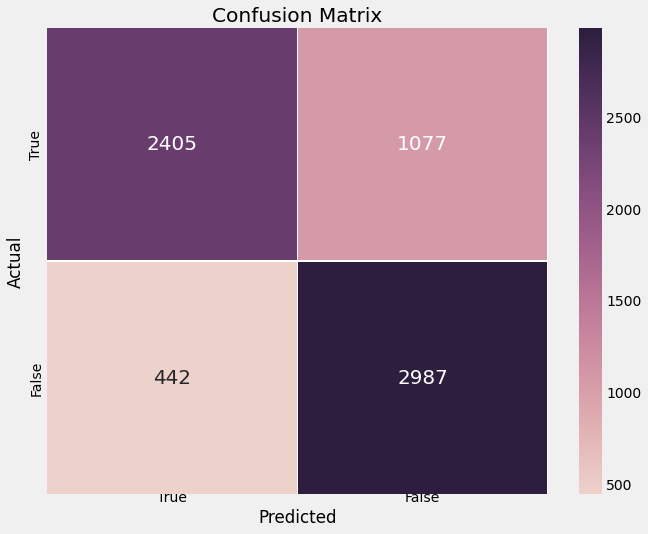

In [96]:
plt.figure(figsize=(10,8))
ax = (sns.heatmap(metrics.confusion_matrix(y_test, y_pred), annot=True, annot_kws={"size": 20}, 
                 linewidths=.1, fmt='d', cmap=sns.cubehelix_palette(as_cmap=True)))
plt.yticks([0.5,1.5,2], ['True', 'False'], va='center', fontsize=14)
plt.xticks([0.5,1.5,2], ['True', 'False'], va='center', fontsize=14)
ax.set_title("Confusion Matrix")
ax.set(xlabel="Predicted", ylabel="Actual");
plt.show()

###Features import

([<matplotlib.axis.XTick at 0x7fed624df588>,
 [Text(0, 0, 'start_date'),
  Text(0, 0, 'start_week'),
  Text(0, 0, 'month_datetime'),
  Text(0, 0, 'day_week'),
  Text(0, 0, 'period_of_the_year')])

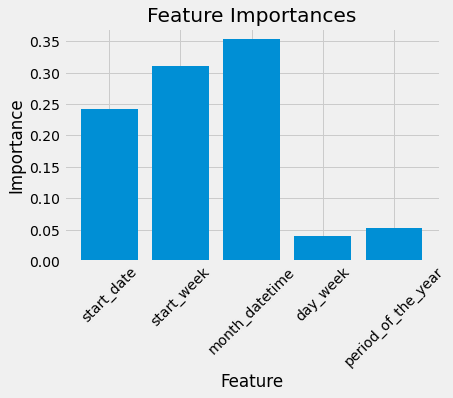

In [97]:
feature_list = ['start_date',	'start_week',	'month_datetime',	'day_week',	'period_of_the_year']
feature_imp = pd.Series(clf.feature_importances_,index=feature_list)

plt.style.use('fivethirtyeight')
x_values = list(range(len(feature_imp)))
plt.bar(x_values, feature_imp, orientation = 'vertical')
plt.xticks(x_values, feature_list)

plt.ylabel('Importance'); plt.xlabel('Feature'); plt.title('Feature Importances')
plt.xticks(x_values, feature_list, rotation='45')

###**II Random Under Sampler (Undersampling instances of the majority class)**

In [217]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler # doctest: +NORMALIZE_WHITESPACE

X_under = copy_df[['case_concept_name', 'start_date',	'start_week',	 'month_datetime',	'day_week',	'period_of_the_year']];
Y_under = copy_df[['label']]

rus = RandomUnderSampler(random_state=42)
X_res_under, y_res_under = rus.fit_resample(X_under, Y_under)

dataset = pd.concat([pd.DataFrame(X_res_under), pd.DataFrame(y_res_under)], axis=1)

# rename the columns
dataset.columns = ['case_concept_name', 'start_date',	'start_week',	 'month_datetime',	'day_week',	'period_of_the_year', 'label']

dataset['label'].value_counts()

#splitting data in train and test sets (70/30)

x_train, x_test = train_test_split(dataset['case_concept_name'].drop_duplicates(), test_size=0.3)
x_train = dataset.merge(x_train, on="case_concept_name")
x_test = dataset.merge(x_test, on="case_concept_name")

y_test = x_test['label'].astype(int)
y_train = x_train['label'].astype(int)
x_train = x_train.drop(['case_concept_name', 'label'], axis=1)
x_test = x_test.drop(['case_concept_name', 'label'], axis=1)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


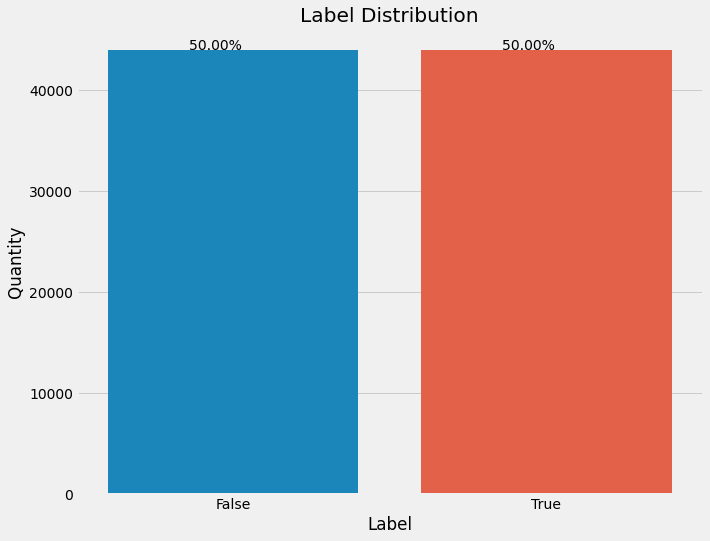

In [218]:
space = '                  '
plt.figure(figsize=[10,8])
labels_occ = dataset['label']
ax = sns.barplot(x=labels_occ.value_counts().index, y=labels_occ.value_counts(), orient='v')

for p in ax.patches:
    (ax.annotate(space + '{:.2f}%'.format(p.get_height()/len(labels_occ)*100), 
                 (p.get_x(), p.get_height()+1), fontsize=14))
ax.set(xlabel="Label", ylabel = "Quantity")
ax.set_title("Label Distribution")
plt.show()

###**Classifiers**

####Logic Regression

In [100]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)

y_pred = logreg.predict(x_test)

acurracy = training_accry = clf.score(x_test, y_test)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
average_precision = average_precision_score(y_test, y_pred)
f1_score = metrics.f1_score(y_test, y_pred)

row_df = pd.DataFrame([pd.Series(['LogisticRegression', 'undersampling', acurracy, precision, recall, average_precision, f1_score])])

novo_df = pd.concat([row_df, novo_df])

print('Precision score: {0:0.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Recall score: {0:0.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Average precision-recall score: {0:0.2f}'.format(average_precision_score(y_test, y_pred)))
print('Average F1 Score score: {0:0.2f}'.format(metrics.f1_score(y_test, y_pred)))

novo_df

Precision score: 0.25
Recall score: 0.50
Average precision-recall score: 0.50
Average F1 Score score: 0.00


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,0,1,2,3,4,5,6
0,LogisticRegression,undersampling,0.788326,0.248465,0.500000,0.503069,0.000000
0,K-Nearest_Neighbors,oversampling,0.780205,0.789870,0.780897,0.704206,0.797277
0,DecisionTree,oversampling,0.780205,0.789870,0.780897,0.704206,0.797277
0,RandomForest,oversampling,0.781363,0.791909,0.782084,0.704938,0.799042
0,LogisticRegression,oversampling,0.762552,0.248083,0.500000,0.496166,0.663250
0,K-Nearest_Neighbors,cost_sensitive_learning,0.783634,0.749749,0.762743,0.544030,0.671664
0,DecisionTree,cost_sensitive_learning,0.783634,0.749749,0.762743,0.544030,0.671664
0,RandomForest,cost_sensitive_learning,0.784152,0.750674,0.765348,0.545919,0.674724
0,LogisticRegression,cost_sensitive_learning,0.783634,0.343459,0.500000,0.313082,0.000000
0,K-Nearest_Neighbors,imbalaced,0.783634,0.749749,0.762743,0.544030,0.671664


###Random Forest

In [101]:
clf = RandomForestClassifier(n_estimators=200, random_state=100)

#Train the model using 
clf.fit(x_train,y_train)

y_pred = clf.predict(x_test)

acurracy = training_accry = clf.score(x_test, y_test)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
average_precision = average_precision_score(y_test, y_pred)
f1_score = metrics.f1_score(y_test, y_pred)

row_df = pd.DataFrame([pd.Series(['RandomForest', 'undersampling', acurracy, precision, recall, average_precision, f1_score])])

novo_df = pd.concat([row_df, novo_df])

print('Precision score: {0:0.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Recall score: {0:0.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Average precision-recall score: {0:0.2f}'.format(average_precision_score(y_test, y_pred)))
print('Average F1 Score score: {0:0.2f}'.format(metrics.f1_score(y_test, y_pred)))

novo_df

Precision score: 0.80
Recall score: 0.79
Average precision-recall score: 0.72
Average F1 Score score: 0.81


,0,1,2,3,4,5,6
0,RandomForest,undersampling,0.790849,0.804567,0.790193,0.716911,0.811869
0,LogisticRegression,undersampling,0.788326,0.248465,0.500000,0.503069,0.000000
0,K-Nearest_Neighbors,oversampling,0.780205,0.789870,0.780897,0.704206,0.797277
0,DecisionTree,oversampling,0.780205,0.789870,0.780897,0.704206,0.797277
0,RandomForest,oversampling,0.781363,0.791909,0.782084,0.704938,0.799042
0,LogisticRegression,oversampling,0.762552,0.248083,0.500000,0.496166,0.663250
0,K-Nearest_Neighbors,cost_sensitive_learning,0.783634,0.749749,0.762743,0.544030,0.671664
0,DecisionTree,cost_sensitive_learning,0.783634,0.749749,0.762743,0.544030,0.671664
0,RandomForest,cost_sensitive_learning,0.784152,0.750674,0.765348,0.545919,0.674724
0,LogisticRegression,cost_sensitive_learning,0.783634,0.343459,0.500000,0.313082,0.000000


###Decision Tree

In [102]:
clf = DecisionTreeClassifier().fit(x_train, y_train)

y_pred = clf.predict(x_test)

acurracy = training_accry = clf.score(x_test, y_test)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
average_precision = average_precision_score(y_test, y_pred)
f1_score = metrics.f1_score(y_test, y_pred)

row_df = pd.DataFrame([pd.Series(['DecisionTree', 'undersampling', acurracy, precision, recall, average_precision, f1_score])])

novo_df = pd.concat([row_df, novo_df])

print('Precision score: {0:0.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Recall score: {0:0.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Average precision-recall score: {0:0.2f}'.format(average_precision_score(y_test, y_pred)))
print('Average F1 Score score: {0:0.2f}'.format(metrics.f1_score(y_test, y_pred)))

novo_df

Precision score: 0.80
Recall score: 0.79
Average precision-recall score: 0.72
Average F1 Score score: 0.81


,0,1,2,3,4,5,6
0,DecisionTree,undersampling,0.791037,0.803734,0.790405,0.717559,0.811380
0,RandomForest,undersampling,0.790849,0.804567,0.790193,0.716911,0.811869
0,LogisticRegression,undersampling,0.788326,0.248465,0.500000,0.503069,0.000000
0,K-Nearest_Neighbors,oversampling,0.780205,0.789870,0.780897,0.704206,0.797277
0,DecisionTree,oversampling,0.780205,0.789870,0.780897,0.704206,0.797277
0,RandomForest,oversampling,0.781363,0.791909,0.782084,0.704938,0.799042
0,LogisticRegression,oversampling,0.762552,0.248083,0.500000,0.496166,0.663250
0,K-Nearest_Neighbors,cost_sensitive_learning,0.783634,0.749749,0.762743,0.544030,0.671664
0,DecisionTree,cost_sensitive_learning,0.783634,0.749749,0.762743,0.544030,0.671664
0,RandomForest,cost_sensitive_learning,0.784152,0.750674,0.765348,0.545919,0.674724


###K-Nearest Neighbors

In [103]:
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)

y_pred = clf.predict(x_test)

acurracy = training_accry = clf.score(x_test, y_test)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
average_precision = average_precision_score(y_test, y_pred)
f1_score = metrics.f1_score(y_test, y_pred)

row_df = pd.DataFrame([pd.Series(['K-Nearest_Neighbors', 'undersampling', acurracy, precision, recall, average_precision, f1_score])])

novo_df = pd.concat([row_df, novo_df])

print('Precision score: {0:0.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Recall score: {0:0.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Average precision-recall score: {0:0.2f}'.format(average_precision_score(y_test, y_pred)))
print('Average F1 Score score: {0:0.2f}'.format(metrics.f1_score(y_test, y_pred)))

novo_df

Precision score: 0.80
Recall score: 0.79
Average precision-recall score: 0.72
Average F1 Score score: 0.81


,0,1,2,3,4,5,6
0,K-Nearest_Neighbors,undersampling,0.791037,0.803734,0.790405,0.717559,0.811380
0,DecisionTree,undersampling,0.791037,0.803734,0.790405,0.717559,0.811380
0,RandomForest,undersampling,0.790849,0.804567,0.790193,0.716911,0.811869
0,LogisticRegression,undersampling,0.788326,0.248465,0.500000,0.503069,0.000000
0,K-Nearest_Neighbors,oversampling,0.780205,0.789870,0.780897,0.704206,0.797277
0,DecisionTree,oversampling,0.780205,0.789870,0.780897,0.704206,0.797277
0,RandomForest,oversampling,0.781363,0.791909,0.782084,0.704938,0.799042
0,LogisticRegression,oversampling,0.762552,0.248083,0.500000,0.496166,0.663250
0,K-Nearest_Neighbors,cost_sensitive_learning,0.783634,0.749749,0.762743,0.544030,0.671664
0,DecisionTree,cost_sensitive_learning,0.783634,0.749749,0.762743,0.544030,0.671664


###Confusion Matrix



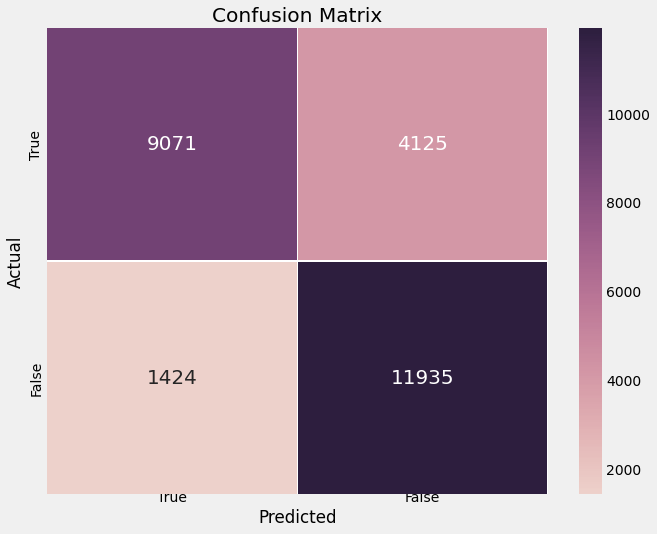

In [104]:
plt.figure(figsize=(10,8))
ax = (sns.heatmap(metrics.confusion_matrix(y_test, y_pred), annot=True, annot_kws={"size": 20}, 
                 linewidths=.1, fmt='d', cmap=sns.cubehelix_palette(as_cmap=True)))
plt.yticks([0.5,1.5,2], ['True', 'False'], va='center', fontsize=14)
plt.xticks([0.5,1.5,2], ['True', 'False'], va='center', fontsize=14)
ax.set_title("Confusion Matrix")
ax.set(xlabel="Predicted", ylabel="Actual");
plt.show()

###Features import

([<matplotlib.axis.XTick at 0x7fed6233feb8>,
 [Text(0, 0, 'start_date'),
  Text(0, 0, 'start_week'),
  Text(0, 0, 'month_datetime'),
  Text(0, 0, 'day_week'),
  Text(0, 0, 'period_of_the_year')])

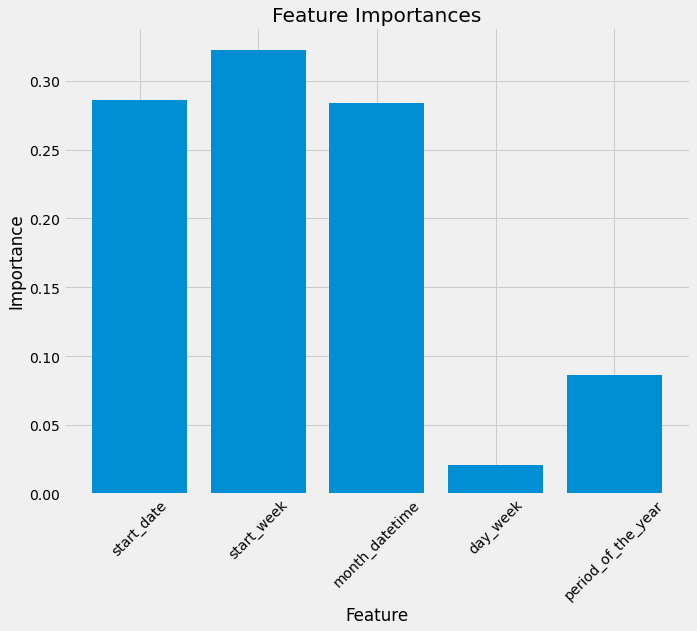

In [105]:
feature_list = ['start_date',	'start_week',	'month_datetime',	'day_week',	'period_of_the_year']
feature_imp = pd.Series(clf.feature_importances_,index=feature_list)

plt.figure(figsize=[10,8])
plt.style.use('fivethirtyeight')
x_values = list(range(len(feature_imp)))
plt.bar(x_values, feature_imp, orientation = 'vertical')
plt.xticks(x_values, feature_list)

plt.ylabel('Importance'); plt.xlabel('Feature'); plt.title('Feature Importances')
plt.xticks(x_values, feature_list, rotation='45')

# **Checking the best metrics results**

In [106]:
result_df = novo_df
# rename the columns
result_df.columns = ['algorithm', 'type', 'acurracy', 'precision', 'recall', 'average_precision', 'f1_score']

result_df

,algorithm,type,acurracy,precision,recall,average_precision,f1_score
0,K-Nearest_Neighbors,undersampling,0.791037,0.803734,0.790405,0.717559,0.811380
0,DecisionTree,undersampling,0.791037,0.803734,0.790405,0.717559,0.811380
0,RandomForest,undersampling,0.790849,0.804567,0.790193,0.716911,0.811869
0,LogisticRegression,undersampling,0.788326,0.248465,0.500000,0.503069,0.000000
0,K-Nearest_Neighbors,oversampling,0.780205,0.789870,0.780897,0.704206,0.797277
0,DecisionTree,oversampling,0.780205,0.789870,0.780897,0.704206,0.797277
0,RandomForest,oversampling,0.781363,0.791909,0.782084,0.704938,0.799042
0,LogisticRegression,oversampling,0.762552,0.248083,0.500000,0.496166,0.663250
0,K-Nearest_Neighbors,cost_sensitive_learning,0.783634,0.749749,0.762743,0.544030,0.671664
0,DecisionTree,cost_sensitive_learning,0.783634,0.749749,0.762743,0.544030,0.671664


##**1 - View result metric within balanced**

In [107]:
temp_df = (result_df[result_df['type'] == 'imbalaced'])
imbalanced_df = temp_df[['algorithm', 'acurracy', 'precision', 'recall', 'average_precision', 'f1_score']].copy(deep=True)

imbalanced_df

,algorithm,acurracy,precision,recall,average_precision,f1_score
0,K-Nearest_Neighbors,0.783634,0.749749,0.762743,0.544030,0.671664
0,DecisionTree,0.783634,0.749749,0.762743,0.544030,0.671664
0,RandomForest,0.784152,0.750674,0.765348,0.545919,0.674724
0,LogisticRegression,0.686918,0.343459,0.500000,0.313082,0.000000


###Result: Metric **Acurracy**

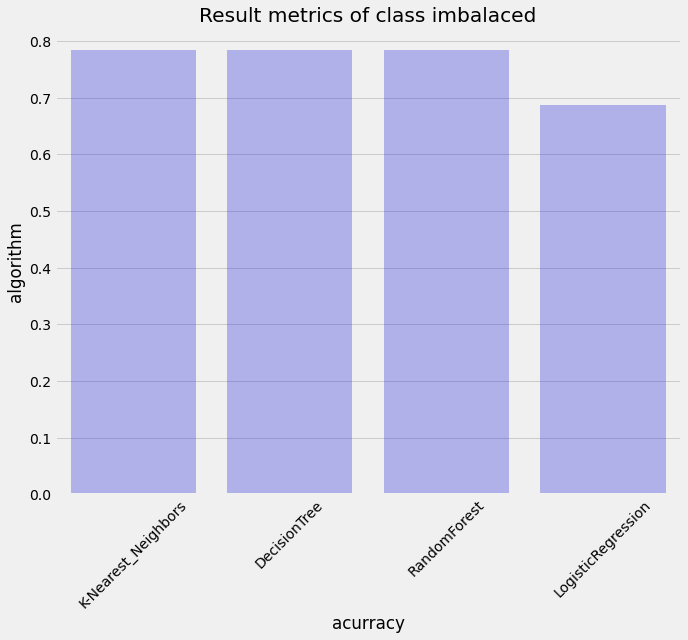

In [108]:
imbalanced_df = temp_df[['algorithm', 'acurracy']].copy(deep=True)

fig, ax = pyplot.subplots(figsize=(10,8))
g = sns.barplot(data = imbalanced_df, x ='algorithm', y= 'acurracy',  alpha=0.3, color="blue");
g.set_xlabel('acurracy')
g.set_ylabel('algorithm')
g.set_title('Result metrics of class imbalaced')
pyplot.xticks(rotation=45);



###Result: Metric **Precision**

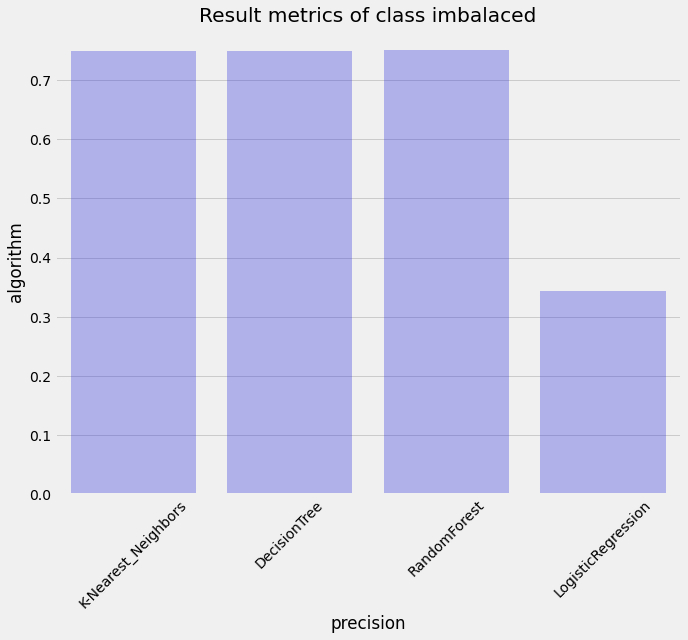

In [109]:
imbalanced_df = temp_df[['algorithm', 'precision']].copy(deep=True)

fig, ax = pyplot.subplots(figsize=(10,8))
g = sns.barplot(data = imbalanced_df, x ='algorithm', y= 'precision',  alpha=0.3, color="blue");
g.set_xlabel('precision')
g.set_ylabel('algorithm')
g.set_title('Result metrics of class imbalaced')
pyplot.xticks(rotation=45);

###Result: Metric **Recall**

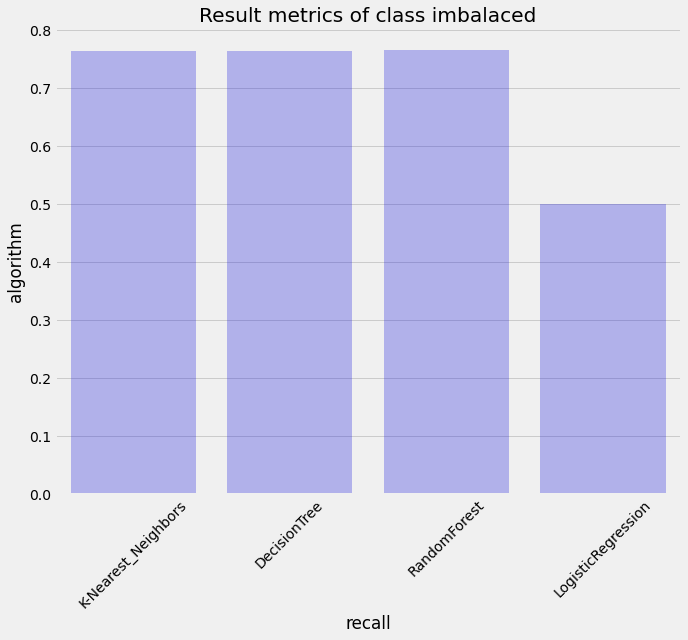

In [110]:
imbalanced_df = temp_df[['algorithm', 'recall']].copy(deep=True)

fig, ax = pyplot.subplots(figsize=(10,8))
g = sns.barplot(data = imbalanced_df, x ='algorithm', y= 'recall',  alpha=0.3, color="blue");
g.set_xlabel('recall')
g.set_ylabel('algorithm')
g.set_title('Result metrics of class imbalaced')
pyplot.xticks(rotation=45);

###Result: Metric **Average Precision**

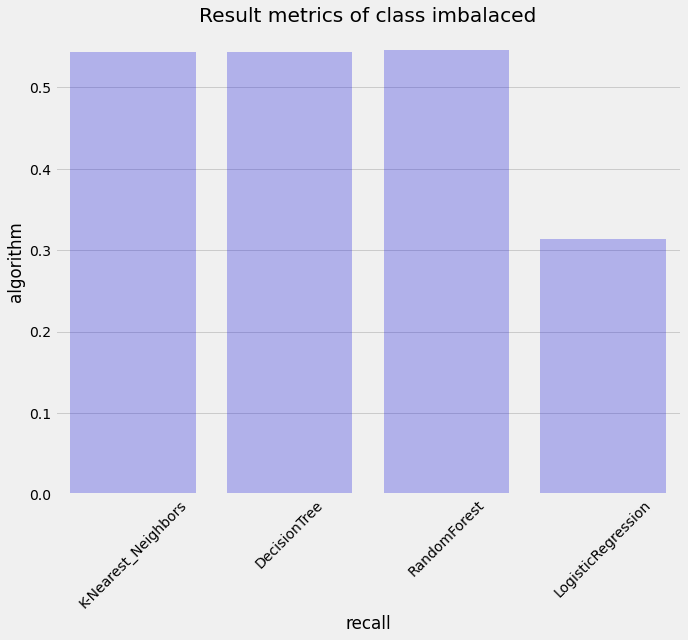

In [111]:
imbalanced_df = temp_df[['algorithm', 'average_precision']].copy(deep=True)

fig, ax = pyplot.subplots(figsize=(10,8))
g = sns.barplot(data = imbalanced_df, x ='algorithm', y= 'average_precision',  alpha=0.3, color="blue");
g.set_xlabel('recall')
g.set_ylabel('algorithm')
g.set_title('Result metrics of class imbalaced')
pyplot.xticks(rotation=45);

###Result: Metric **F1 Score**


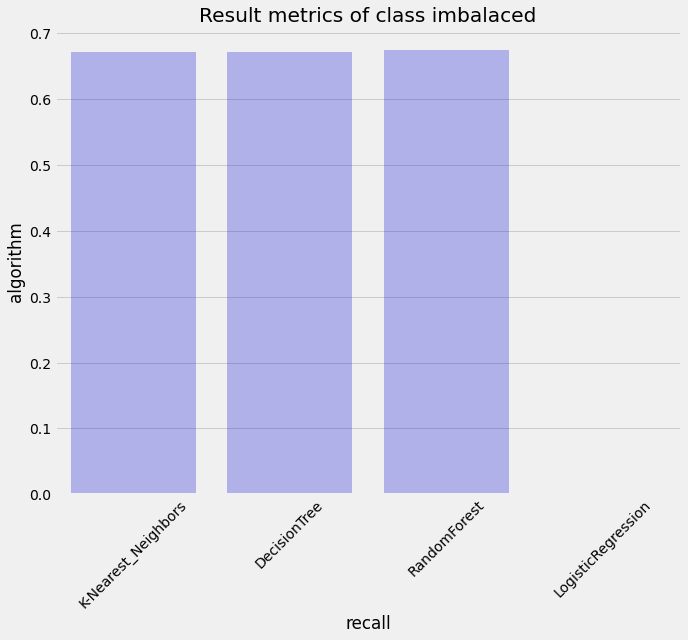

In [112]:
imbalanced_df = temp_df[['algorithm', 'f1_score']].copy(deep=True)

fig, ax = pyplot.subplots(figsize=(10,8))
g = sns.barplot(data = imbalanced_df, x ='algorithm', y= 'f1_score',  alpha=0.3, color="blue");
g.set_xlabel('recall')
g.set_ylabel('algorithm')
g.set_title('Result metrics of class imbalaced')
pyplot.xticks(rotation=45);

##**2 - View result metric with Simple (Undersampling)**

In [113]:
temp_df = (result_df[result_df['type'] == 'undersampling'])
imbalanced_df = temp_df[['algorithm', 'acurracy', 'precision', 'recall', 'average_precision', 'f1_score']].copy(deep=True)

imbalanced_df

,algorithm,acurracy,precision,recall,average_precision,f1_score
0,K-Nearest_Neighbors,0.791037,0.803734,0.790405,0.717559,0.811380
0,DecisionTree,0.791037,0.803734,0.790405,0.717559,0.811380
0,RandomForest,0.790849,0.804567,0.790193,0.716911,0.811869
0,LogisticRegression,0.788326,0.248465,0.500000,0.503069,0.000000


###Result: Metric **Acurracy**

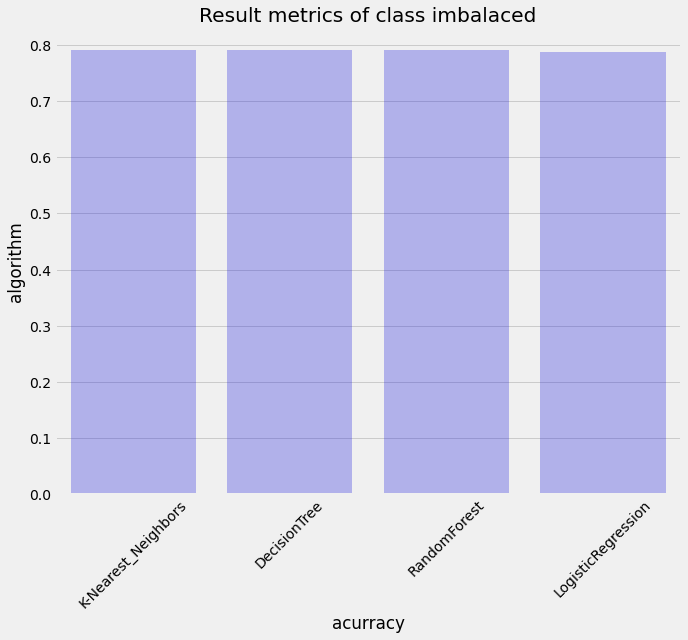

In [114]:
imbalanced_df = temp_df[['algorithm', 'acurracy']].copy(deep=True)

fig, ax = pyplot.subplots(figsize=(10,8))
g = sns.barplot(data = imbalanced_df, x ='algorithm', y= 'acurracy',  alpha=0.3, color="blue");
g.set_xlabel('acurracy')
g.set_ylabel('algorithm')
g.set_title('Result metrics of class imbalaced')
pyplot.xticks(rotation=45);



###Result: Metric **Precision**

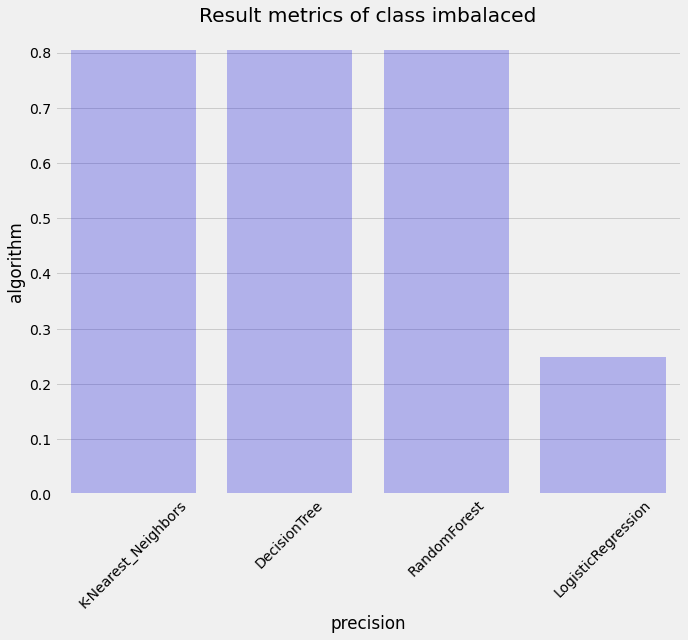

In [115]:
imbalanced_df = temp_df[['algorithm', 'precision']].copy(deep=True)

fig, ax = pyplot.subplots(figsize=(10,8))
g = sns.barplot(data = imbalanced_df, x ='algorithm', y= 'precision',  alpha=0.3, color="blue");
g.set_xlabel('precision')
g.set_ylabel('algorithm')
g.set_title('Result metrics of class imbalaced')
pyplot.xticks(rotation=45);

###Result: Metric **Recall**

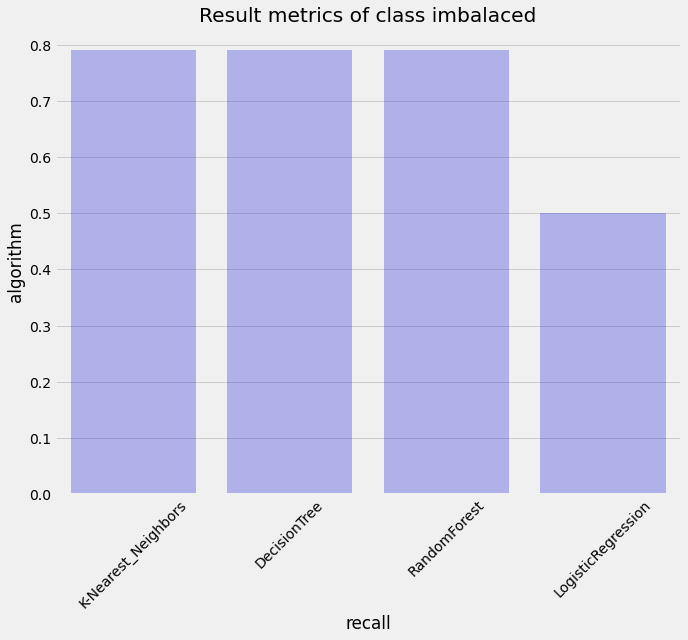

In [116]:
imbalanced_df = temp_df[['algorithm', 'recall']].copy(deep=True)

fig, ax = pyplot.subplots(figsize=(10,8))
g = sns.barplot(data = imbalanced_df, x ='algorithm', y= 'recall',  alpha=0.3, color="blue");
g.set_xlabel('recall')
g.set_ylabel('algorithm')
g.set_title('Result metrics of class imbalaced')
pyplot.xticks(rotation=45);

###Result: Metric **Average Precision**

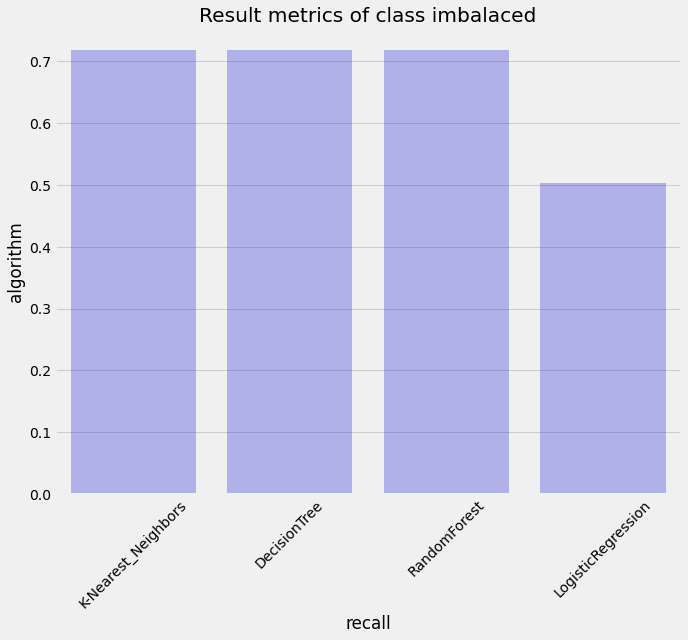

In [117]:
imbalanced_df = temp_df[['algorithm', 'average_precision']].copy(deep=True)

fig, ax = pyplot.subplots(figsize=(10,8))
g = sns.barplot(data = imbalanced_df, x ='algorithm', y= 'average_precision',  alpha=0.3, color="blue");
g.set_xlabel('recall')
g.set_ylabel('algorithm')
g.set_title('Result metrics of class imbalaced')
pyplot.xticks(rotation=45);

###Result: Metric **F1 Score**


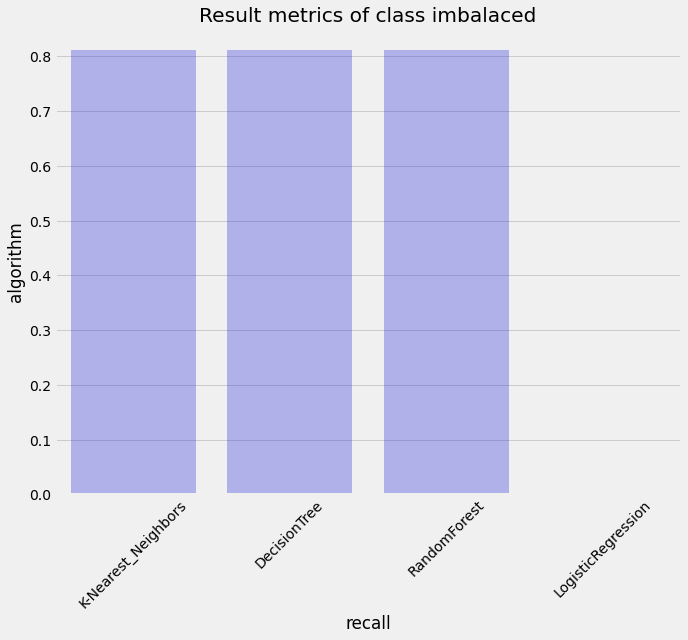

In [118]:
imbalanced_df = temp_df[['algorithm', 'f1_score']].copy(deep=True)

fig, ax = pyplot.subplots(figsize=(10,8))
g = sns.barplot(data = imbalanced_df, x ='algorithm', y= 'f1_score',  alpha=0.3, color="blue");
g.set_xlabel('recall')
g.set_ylabel('algorithm')
g.set_title('Result metrics of class imbalaced')
pyplot.xticks(rotation=45);

##**3 - View result metric with Simple (Oversampling)**

In [119]:
temp_df = (result_df[result_df['type'] == 'oversampling'])
imbalanced_df = temp_df[['algorithm', 'acurracy', 'precision', 'recall', 'average_precision', 'f1_score']].copy(deep=True)

imbalanced_df

,algorithm,acurracy,precision,recall,average_precision,f1_score
0,K-Nearest_Neighbors,0.780205,0.789870,0.780897,0.704206,0.797277
0,DecisionTree,0.780205,0.789870,0.780897,0.704206,0.797277
0,RandomForest,0.781363,0.791909,0.782084,0.704938,0.799042
0,LogisticRegression,0.762552,0.248083,0.500000,0.496166,0.663250


###Result: Metric **Acurracy**

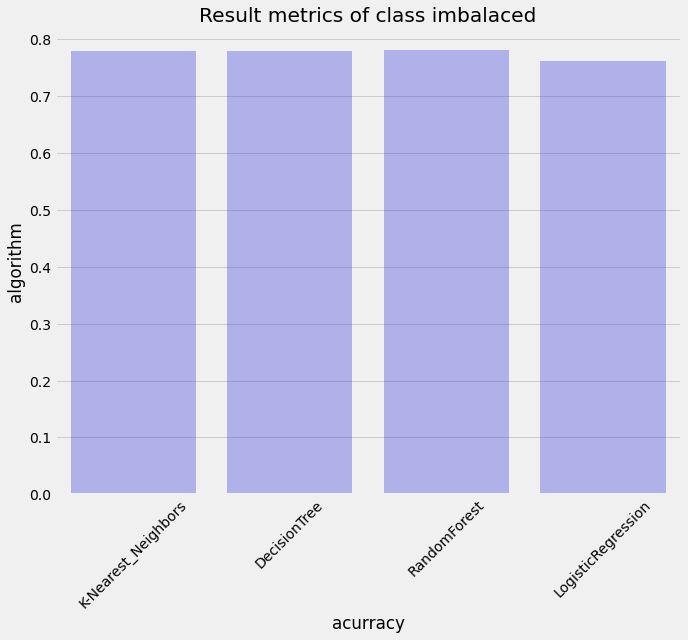

In [120]:
imbalanced_df = temp_df[['algorithm', 'acurracy']].copy(deep=True)

fig, ax = pyplot.subplots(figsize=(10,8))
g = sns.barplot(data = imbalanced_df, x ='algorithm', y= 'acurracy',  alpha=0.3, color="blue");
g.set_xlabel('acurracy')
g.set_ylabel('algorithm')
g.set_title('Result metrics of class imbalaced')
pyplot.xticks(rotation=45);



###Result: Metric **Precision**

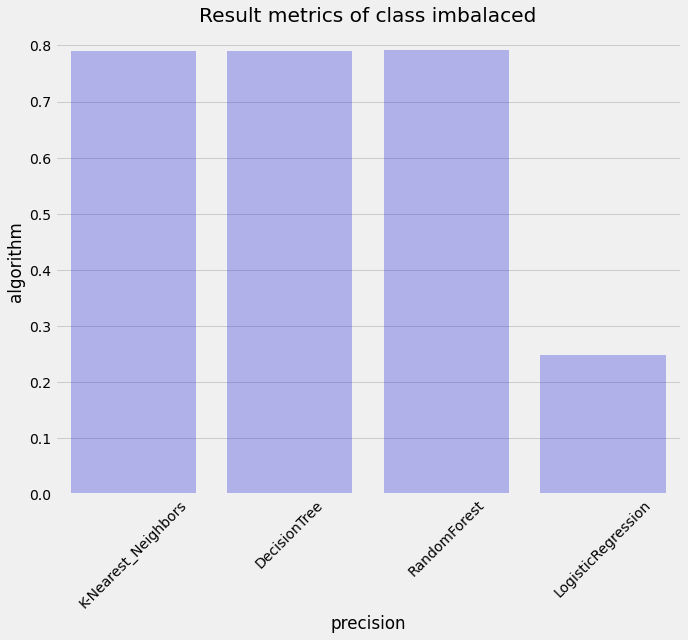

In [121]:
imbalanced_df = temp_df[['algorithm', 'precision']].copy(deep=True)

fig, ax = pyplot.subplots(figsize=(10,8))
g = sns.barplot(data = imbalanced_df, x ='algorithm', y= 'precision',  alpha=0.3, color="blue");
g.set_xlabel('precision')
g.set_ylabel('algorithm')
g.set_title('Result metrics of class imbalaced')
pyplot.xticks(rotation=45);

###Result: Metric **Recall**

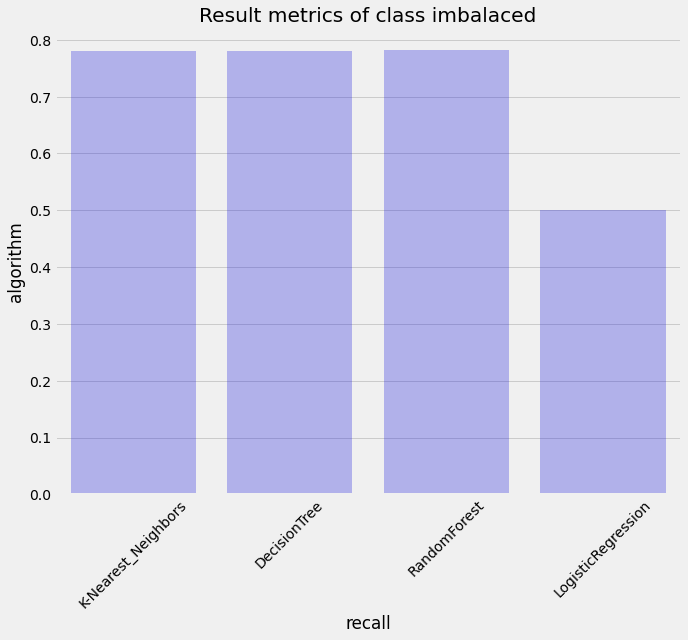

In [122]:
imbalanced_df = temp_df[['algorithm', 'recall']].copy(deep=True)

fig, ax = pyplot.subplots(figsize=(10,8))
g = sns.barplot(data = imbalanced_df, x ='algorithm', y= 'recall',  alpha=0.3, color="blue");
g.set_xlabel('recall')
g.set_ylabel('algorithm')
g.set_title('Result metrics of class imbalaced')
pyplot.xticks(rotation=45);

###Result: Metric **Average Precision**

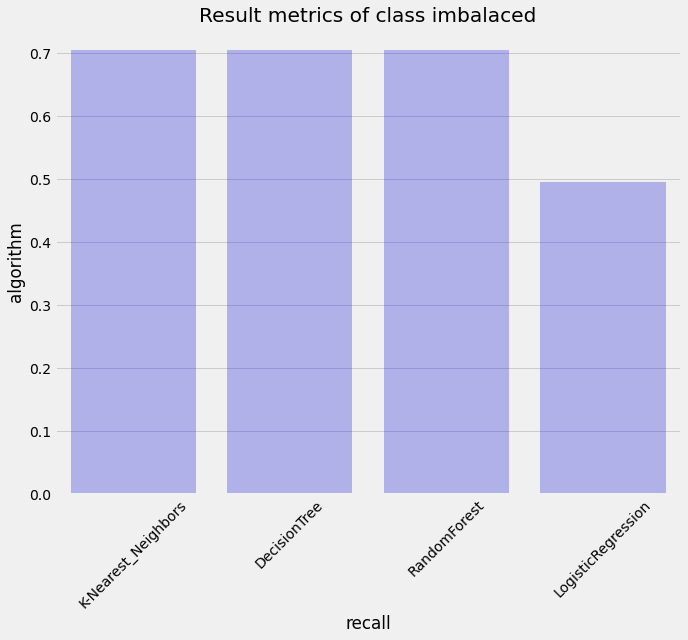

In [123]:
imbalanced_df = temp_df[['algorithm', 'average_precision']].copy(deep=True)

fig, ax = pyplot.subplots(figsize=(10,8))
g = sns.barplot(data = imbalanced_df, x ='algorithm', y= 'average_precision',  alpha=0.3, color="blue");
g.set_xlabel('recall')
g.set_ylabel('algorithm')
g.set_title('Result metrics of class imbalaced')
pyplot.xticks(rotation=45);

###Result: Metric **F1 Score**


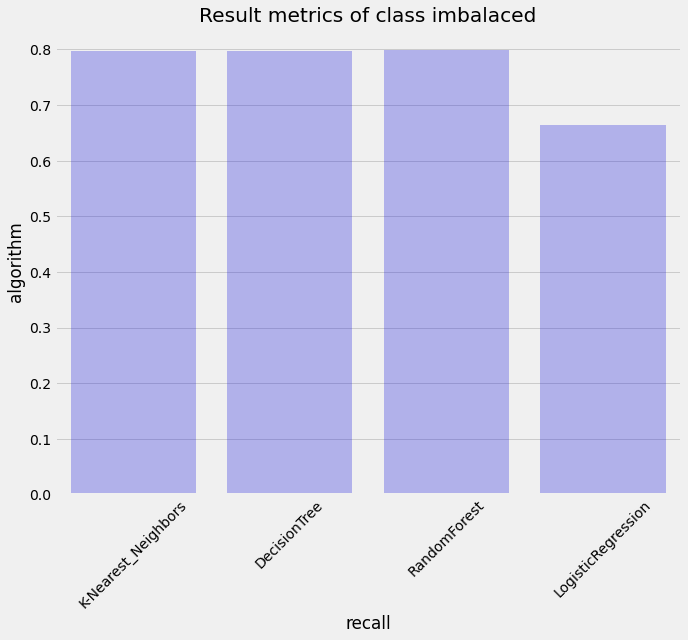

In [124]:
imbalanced_df = temp_df[['algorithm', 'f1_score']].copy(deep=True)

fig, ax = pyplot.subplots(figsize=(10,8))
g = sns.barplot(data = imbalanced_df, x ='algorithm', y= 'f1_score',  alpha=0.3, color="blue");
g.set_xlabel('recall')
g.set_ylabel('algorithm')
g.set_title('Result metrics of class imbalaced')
pyplot.xticks(rotation=45);

##**4 - View result metric with Cost Sensitive Learning**

In [125]:
temp_df = (result_df[result_df['type'] == 'cost_sensitive_learning'])
imbalanced_df = temp_df[['algorithm', 'acurracy', 'precision', 'recall', 'average_precision', 'f1_score']].copy(deep=True)

imbalanced_df

,algorithm,acurracy,precision,recall,average_precision,f1_score
0,K-Nearest_Neighbors,0.783634,0.749749,0.762743,0.544030,0.671664
0,DecisionTree,0.783634,0.749749,0.762743,0.544030,0.671664
0,RandomForest,0.784152,0.750674,0.765348,0.545919,0.674724
0,LogisticRegression,0.783634,0.343459,0.500000,0.313082,0.000000


###Result: Metric **Acurracy**

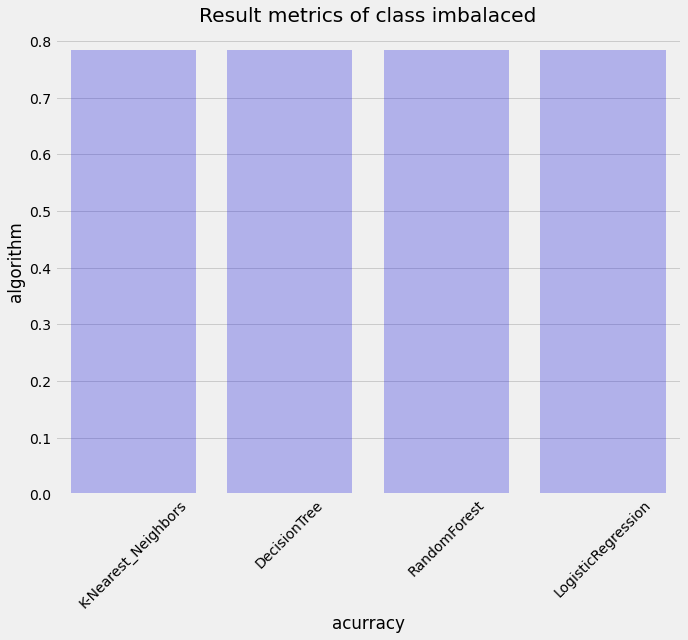

In [126]:
imbalanced_df = temp_df[['algorithm', 'acurracy']].copy(deep=True)

fig, ax = pyplot.subplots(figsize=(10,8))
g = sns.barplot(data = imbalanced_df, x ='algorithm', y= 'acurracy',  alpha=0.3, color="blue");
g.set_xlabel('acurracy')
g.set_ylabel('algorithm')
g.set_title('Result metrics of class imbalaced')
pyplot.xticks(rotation=45);



###Result: Metric **Precision**

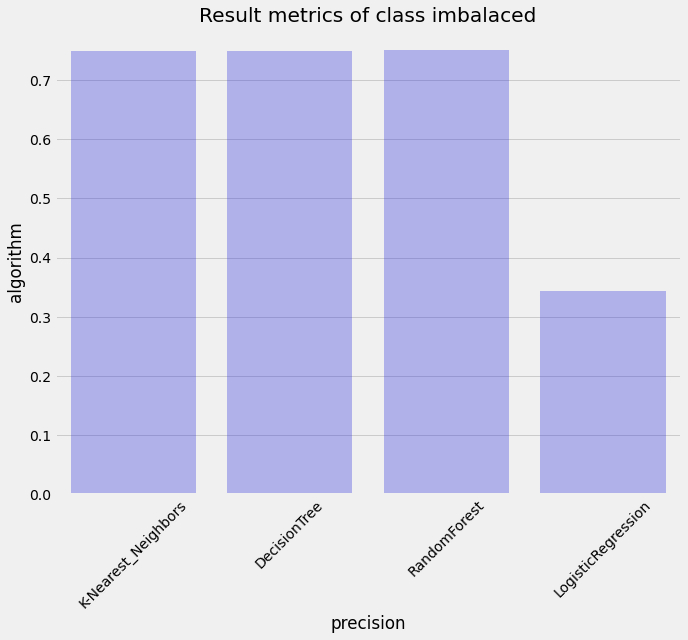

In [127]:
imbalanced_df = temp_df[['algorithm', 'precision']].copy(deep=True)

fig, ax = pyplot.subplots(figsize=(10,8))
g = sns.barplot(data = imbalanced_df, x ='algorithm', y= 'precision',  alpha=0.3, color="blue");
g.set_xlabel('precision')
g.set_ylabel('algorithm')
g.set_title('Result metrics of class imbalaced')
pyplot.xticks(rotation=45);

###Result: Metric **Recall**

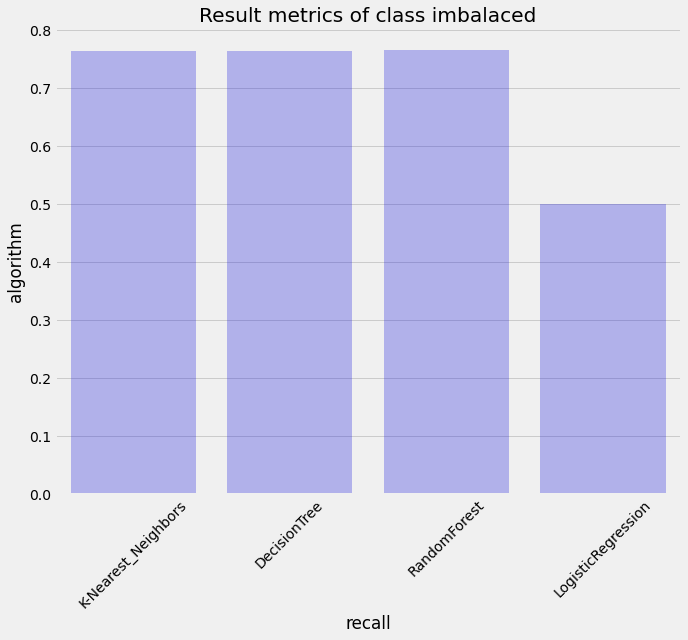

In [128]:
imbalanced_df = temp_df[['algorithm', 'recall']].copy(deep=True)

fig, ax = pyplot.subplots(figsize=(10,8))
g = sns.barplot(data = imbalanced_df, x ='algorithm', y= 'recall',  alpha=0.3, color="blue");
g.set_xlabel('recall')
g.set_ylabel('algorithm')
g.set_title('Result metrics of class imbalaced')
pyplot.xticks(rotation=45);

###Result: Metric **Average Precision**

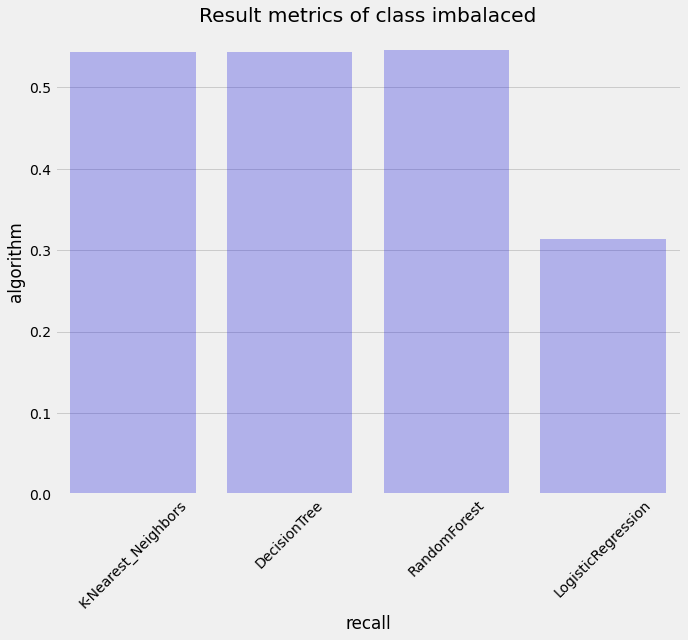

In [129]:
imbalanced_df = temp_df[['algorithm', 'average_precision']].copy(deep=True)

fig, ax = pyplot.subplots(figsize=(10,8))
g = sns.barplot(data = imbalanced_df, x ='algorithm', y= 'average_precision',  alpha=0.3, color="blue");
g.set_xlabel('recall')
g.set_ylabel('algorithm')
g.set_title('Result metrics of class imbalaced')
pyplot.xticks(rotation=45);

###Result: Metric **F1 Score**


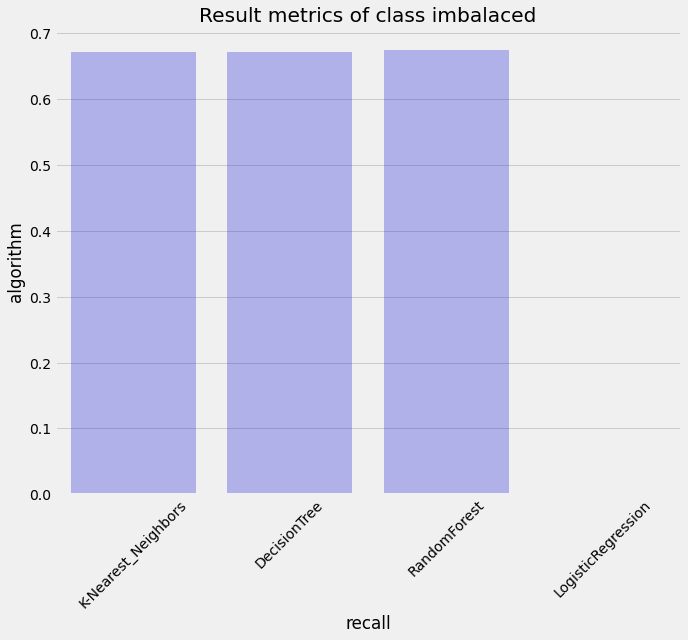

In [130]:
imbalanced_df = temp_df[['algorithm', 'f1_score']].copy(deep=True)

fig, ax = pyplot.subplots(figsize=(10,8))
g = sns.barplot(data = imbalanced_df, x ='algorithm', y= 'f1_score',  alpha=0.3, color="blue");
g.set_xlabel('recall')
g.set_ylabel('algorithm')
g.set_title('Result metrics of class imbalaced')
pyplot.xticks(rotation=45);

###**5 - Melhores resultados da metrica F1 Score**

In [139]:
fi_score_df = result_df[['algorithm', 'type', 'f1_score']].copy(deep=True)
fi_score_df.sort_values(['f1_score'])

,algorithm,type,f1_score
0,LogisticRegression,undersampling,0.000000
0,LogisticRegression,cost_sensitive_learning,0.000000
0,LogisticRegression,imbalaced,0.000000
0,LogisticRegression,oversampling,0.663250
0,K-Nearest_Neighbors,cost_sensitive_learning,0.671664
0,DecisionTree,cost_sensitive_learning,0.671664
0,K-Nearest_Neighbors,imbalaced,0.671664
0,DecisionTree,imbalaced,0.671664
0,RandomForest,cost_sensitive_learning,0.674724
0,RandomForest,imbalaced,0.674724


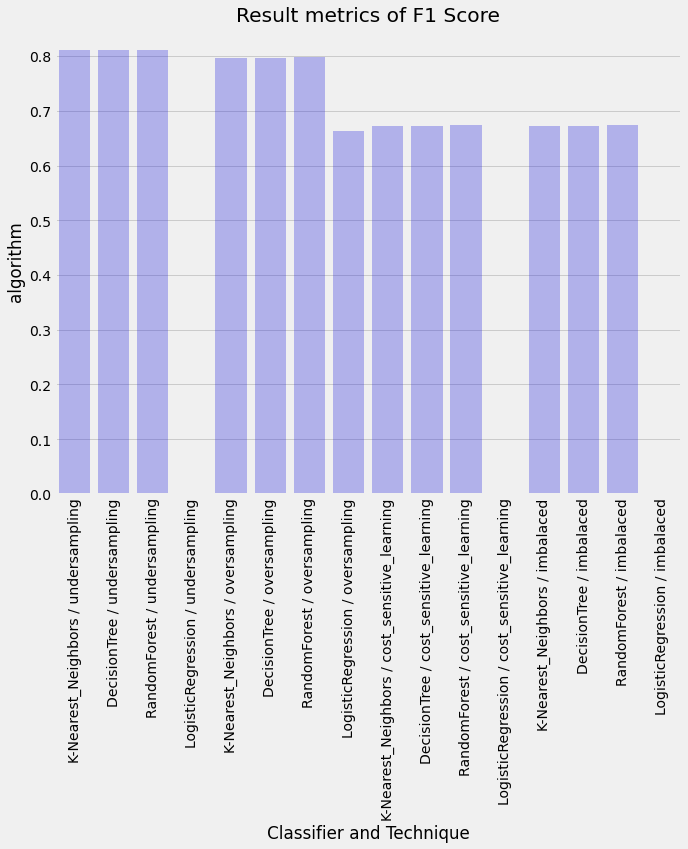

In [216]:
fi_score_df = result_df[['algorithm', 'type', 'f1_score']].copy(deep=True)
fi_score_df.sort_values(['f1_score'])

fi_score_df['columns_concat'] = fi_score_df[['algorithm', 'type']].agg(' / '.join, axis=1)

fig, ax = pyplot.subplots(figsize=(10,8))
g = sns.barplot(data = fi_score_df, x ='columns_concat', y= 'f1_score',  alpha=0.3, color="blue");
g.set_xlabel('Classifier and Technique')
g.set_ylabel('algorithm')
g.set_title('Result metrics of F1 Score')

pyplot.xticks(rotation=90);

In [211]:
fi_score_df = result_df[['algorithm', 'type', 'acurracy', 'f1_score']]

acurracy = result_df['acurracy'].astype(float)
precision = result_df['precision'].astype(float)
recall = result_df['recall'].astype(float)
average_precision = result_df['average_precision'].astype(float)
f1_score = result_df['f1_score'].astype(float)

result_df.head(20)

,algorithm,type,acurracy,precision,recall,average_precision,f1_score
0,K-Nearest_Neighbors,undersampling,0.791037,0.803734,0.790405,0.717559,0.811380
0,DecisionTree,undersampling,0.791037,0.803734,0.790405,0.717559,0.811380
0,RandomForest,undersampling,0.790849,0.804567,0.790193,0.716911,0.811869
0,LogisticRegression,undersampling,0.788326,0.248465,0.500000,0.503069,0.000000
0,K-Nearest_Neighbors,oversampling,0.780205,0.789870,0.780897,0.704206,0.797277
0,DecisionTree,oversampling,0.780205,0.789870,0.780897,0.704206,0.797277
0,RandomForest,oversampling,0.781363,0.791909,0.782084,0.704938,0.799042
0,LogisticRegression,oversampling,0.762552,0.248083,0.500000,0.496166,0.663250
0,K-Nearest_Neighbors,cost_sensitive_learning,0.783634,0.749749,0.762743,0.544030,0.671664
0,DecisionTree,cost_sensitive_learning,0.783634,0.749749,0.762743,0.544030,0.671664


#**Conclusion**

##For a better classification of the data some class balancing techniques were used. The best metrics for calculating unbalanced data is F! Score, as it is a weighted average of the Precision and Recall metrics, being able to measure at the same time how accurate your prediction is and how comprehensive it is within the positive class. Thus, it is more robust than accuracy, which looks only at how much you got right in total. The best metric was RandomForest using the sample technique (Undersampling) obtaining the result of 0.8113